<h1>Manuscript Code</h1>
<p>The following code was used to analyze and generate data for this manuscript. The output of some cells is deleted to increase readability; these cells can be expanded to show full output. While this is not the actual run that was used, the code itself is designed to be reproducible such that equivalent output files can be created from running it. These are equivalent and not identical output files because processes like denoising, taxonomy classification, Inchikey assignment, etc. will produce different results each time they are run. This is mitigated to some degree by the use of random seeds whenever possible, but slight differences in the abundance of individual taxa and metabolites will inevitably arise.</p>

<h3>Environment Setup and Initial Metadata Processing</h3>

In [1]:
import dokdo
import qiime2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import psutil
import re
import rpy2
import math
import requests
import sklearn
import urllib

# This is a custom module with functions related to handling Qiime2 data
import q2Handler

# This little bit of code imports all of the available qiime2 plugins instead of needing to manually import them 1 by 1. 
# If qiime2 is imported without Dokdo, the plugins module will have to be imported
# from qiime2 individually (a la 'from qiime2 import plugins')
for plugin in qiime2.plugins.available_plugins():
    qiime2.plugins.importlib.import_module(plugin)
    
%matplotlib inline
%load_ext rpy2.ipython
sns.set()

In [2]:
### Global Variables ###
# Changing baseDir should allow all code in this notebook to be recreated in an arbitrary location,
# provided that the necessary input files (sequences, metadata, metabolites) are in a directory
# called "data" with subdirectories respectively named "16S", "metadata", and "metabolomics".
n_cores = len(psutil.Process().cpu_affinity())
baseDir = pathlib.Path('/work/claytonlab/jhernandez/projects/temp_marm_microbiome')
dataDir = baseDir.joinpath('data')
metaFileDir = dataDir.joinpath('metadata')
seqFileDir = dataDir.joinpath('16S')
metabFileDir = dataDir.joinpath('metabolomics')
analysisDir = baseDir.joinpath('analysis')
artifactDir = analysisDir.joinpath('16S/q2_artifacts')
manifestDir = analysisDir.joinpath('edited_metadata_and_manifests')
figureDir = analysisDir.joinpath('figures')

# Directories are made if they don't exist
for dir in (baseDir, dataDir, metaFileDir, seqFileDir, metabFileDir, analysisDir, artifactDir, manifestDir, figureDir):
    if not dir.exists():
        dir.mkdir(parents=True)

figurePath = figureDir.as_posix()

In [3]:
### Sample Metadata Formatting and Processing ###
sampleMeta = pd.read_csv(dataDir.joinpath('metadata/metadata.tsv'), sep='\t', skiprows=[1])[['sample-id', 'individual', 'condition', 'date', 'cage', 'sex']]
sampleMeta.columns = sampleMeta.columns.str.capitalize()
sampleMeta = sampleMeta.rename(columns={'Sample-id': 'Sample_ID'}).astype(str)
sampleMeta[['Individual', 'Condition', 'Cage', 'Sex']] = sampleMeta[['Individual', 'Condition', 'Cage', 'Sex']].apply(lambda x: x.str.capitalize())
sampleMeta['Date'] = pd.to_datetime(sampleMeta['Date'], format='%m/%d/%y')
sampleMeta.sort_values(by=['Individual', 'Date'], inplace=True)

# A Relative_Day column is created, which measures the time in days relative to the earliest date available for each individual
sampleMeta['Relative_Day'] = sampleMeta.apply((lambda x: (x['Date'] - sampleMeta.loc[sampleMeta['Individual'] == x['Individual']]['Date'].min()).days), axis=1)

# A new column is created that de-identifies marmosets (Names are changed to Marm_01, Marm_02, etc)
uniqueMarms = sampleMeta['Individual'].unique()
anonMarms = dict(zip(uniqueMarms, [str(num).zfill(math.floor(math.log10(uniqueMarms.shape[0])) + 1) for num in np.arange(1, uniqueMarms.shape[0]+1)]))
sampleMeta['Anon_Individual'] = sampleMeta['Individual'].apply(lambda x: 'Marm_{num}'.format(num=anonMarms.get(x)))

# A Qiime2-friendly metadata sheet is created and the sampleMeta dataframe is reindexed by Sample_ID
sampleMeta.rename(columns={'Sample_ID': 'sample-id'}).to_csv(manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), index=False, sep='\t')
sampleMeta.set_index('Sample_ID', inplace=True)

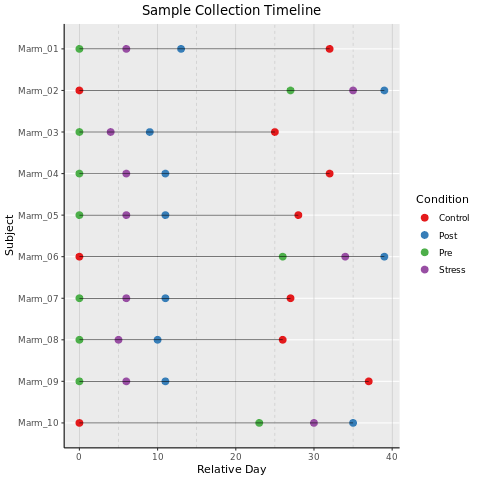

In [4]:
%%R -i sampleMeta,figurePath
library('ggplot2')
library('forcats')

# A plot with collected samples and their time points is created
# Useful for creating themes:
# https://ggplot2.tidyverse.org/reference/theme.html
samplePlot <- ggplot(data=sampleMeta, aes(x=Relative_Day, y=fct_rev(Anon_Individual))) + 
    geom_point(aes(color=Condition), size=3) + geom_line(size=0.25) + 
    scale_color_brewer(palette='Set1') +
    theme(axis.line = element_line(color='black'),
    plot.background = element_rect(fill='white'),
    panel.grid.major.x = element_line(color = 'gray', size = 0.25),
    panel.grid.minor.x = element_line(color = 'gray', size = 0.25, linetype=2),
    panel.border = element_blank(),
    plot.title = element_text(hjust = 0.5),
    legend.key = element_blank()) +
    ylab('Subject') + xlab('Relative Day') + ggtitle('Sample Collection Timeline')
    
plot(samplePlot)
ggsave('sampleCollectionTimeline.pdf', plot=samplePlot, device='pdf', path=figurePath, width=5, height=5, units='in')

<p>This cell is comprised of many R functions that are called later in the pipeline, many of which were modified from code originally made available by  <a href="https://bitbucket.org/biobakery/hmp2_workflows/src/master/">Lloyd-Price et al</a>. The cell is very large, but it can be run while minimized to help save space.</p>

In [5]:
%%R
### Various R Functions ###
convertDF <- function(df, meta) {
    dfDat <- list(x=df, metaS=as.data.frame(lapply(meta[rownames(df), ], as.factor)))
    rownames(dfDat$metaS) <- rownames(meta)
    return(dfDat)
}

# This function calculates the bray-curtis dissimilarity matrix for a dataset and runs a PERMANOVA for between- and within-subject factors.
# The PERMANOVA does 10000 permutations. Here are good sources for learning more:
# https://uw.pressbooks.pub/appliedmultivariatestatistics/chapter/permanova/
# https://uw.pressbooks.pub/appliedmultivariatestatistics/chapter/restricting-permutations/
# https://stats.stackexchange.com/questions/590510/repeated-measures-permanova-nowhere-to-find
runPermStress <- function(df) {
    library('vegan')
    library('labdsv')
    set.seed(13)
    D <- dsvdis(df$x, index="bray/curtis")
    within_perm <- how(nperm=9999, plots = Plots(strata=df$metaS$Individual, type = "none"), within=Within(type='free'), observed=TRUE)
    bet_perm <- how(nperm=9999, plots=Plots(strata=df$metaS$Individual, type='free'), within=Within(type='none'), observed=TRUE)
    withinRes <- adonis2(D ~ Individual + Condition, data=df$metaS, permutation=within_perm)
    betRes <- adonis2(D ~ Sex + Cage + Individual, data=df$metaS, permutation=bet_perm)
    set.seed(Sys.time())
    return(list(betRes, withinRes))
}

runPermNoStress <- function(df) {
    library('vegan')
    library('labdsv')
    set.seed(13)
    D <- dsvdis(df$x, index="bray/curtis")
    within_perm <- how(nperm=9999, plots = Plots(strata=df$metaS$Individual, type = "none"), within=Within(type='free'), observed=TRUE)
    bet_perm <- how(nperm=9999, plots=Plots(strata=df$metaS$Individual, type='free'), within=Within(type='none'), observed=TRUE)
    withinRes <- adonis2(D ~ Individual + Relative_Day, data=df$metaS, permutation=within_perm)
    betRes <- adonis2(D ~ Sex + Cage + Individual, data=df$metaS, permutation=bet_perm)
    set.seed(Sys.time())
    return(list(betRes, withinRes))
}


# Calculates bray-curtis distance (optional) and performs a PCoA
PCoA <- function(dat, D=NA, k=2) {
    library('vegan')
    library('labdsv')
    x <- dat$x
    k <- max(k, 2)
    D <- dsvdis(x, index="bray/curtis")
    pc <- pco(D, k)
    ord <- pc
    toteig <- sum(pc$eig[pc$eig>0])
    ord$ordnames <- sprintf("PCo %d (%0.1f%%)", 1:k, 100 * pc$eig[1:k] / toteig)
    return (ord)
}

ordplot <- function(dat, ord, pcos = 2, pointoutline = T,
        colour = NA, colour_title = NA, colour_names = NA, colour_override = NA,
        shape = NA,  shape_title = NA,  shape_names = NA,  shape_override = NA,
        size = NA, size_title = NA, size_names = NA, size_override = NA,
        size_abs = NA, outline_size = NA,
        surface = NA, surf_maj_lines = 8, surf_min_lines = 4, surf_extent = 1,
        surf_smoothness = 1, surf_quality = 100,
        centroid = NA, loading = NA, sigloadings = NA,
        enriched = NA, text_halo = T,
        colour_log = F, colour_log_pseudocount = 0, colour_log_base = 10,
        arrows_fixed = NULL, arrows = NULL, arrow_text = T, arrow_sqrtnorm = T,
        connect = NA, sequence = NA, connectwidth = NA, sortby = NA, decreasing = F) {

    library('ggplot2')
    library('ggpubr')
    # ggplot2-based function to visualize the results of an ordination
    dat$meta <- dat$metaS
    
    

    # Set up the plot
    ggp <- ggplot() + theme_classic() +
        theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())
    gptopt <- list()
    gptaes <- list(x="dim1", y="dim2")

    # Get the dimensions to plot, and set the axes appropriately
    if (length(pcos) == 1) {
        pcos <- max(pcos,2)
        pcos <- c(pcos-1, pcos)
    } else {
        stopifnot(length(pcos) == 2)
    }
    stopifnot(max(pcos) <= dim(ord$points)[2])
    pts <- as.data.frame(ord$points[,pcos])
    if (is.null(ord$ordnames)) {
        dims <- colnames(pts)
    } else {
        dims <- ord$ordnames[pcos]
    }
    colnames(pts) <- c("dim1", "dim2")
    ggp <- ggp + xlab(dims[1]) + ylab(dims[2])

    # Use this mapping to allow the ordination to be done on a subset of the
    # data without requiring that dat also be that subset
    metamatch <- match(rownames(pts), rownames(dat$x))
    if (any(is.na(metamatch))) {
        pts <- pts[!is.na(metamatch),]
        metamatch <- metamatch[!is.na(metamatch)]
    }

    getmeta <- function(name) {
        tgt <- name == colnames(dat$meta)
        if (any(tgt)) {
            return (dat$meta[metamatch,tgt])
        }
        tgt <- name == colnames(dat$x)
        if (any(tgt)) {
            return (dat$x[metamatch,min(which(tgt))])
        }

        stop(sprintf("%s is not a metadata or feature.", name))
    }

    # Apply sorting
    if (!is.na(sortby)) {
        s <- getmeta(sortby)
        pts <- pts[order(s, decreasing=decreasing),]
        metamatch <- match(rownames(pts), rownames(dat$x))
    }

    # Draw connectors first
    if (!is.na(connect) || !is.na(sequence)) {
        df <- data.frame(x=pts$dim1, y=pts$dim2)

        if (!is.na(connect)) {
            connectby <- getmeta(connect)
            df$group <- connectby
        }
        if (!is.na(sequence)) {
            seqby <- getmeta(sequence)
            df <- df[order(seqby),]
        }
        if (!is.na(connect)) {
            ggp <- ggp + geom_path(data=df, aes(x=x, y=y, group=group), size=ifelse(is.na(connectwidth), 1, connectwidth))
        } else {
            ggp <- ggp + geom_path(data=df, aes(x=x, y=y), size=ifelse(is.na(connectwidth), 1, connectwidth))
        }
    }

    # Draw the surface
    if (!is.na(surface)) {
        surfby <- getmeta(surface)

        # pick an appropriate bandwidth
        bw1 <- surf_smoothness * 1.06 * sd(pts$dim1) * length(pts$dim1)^-0.2
        bw2 <- surf_smoothness * 1.06 * sd(pts$dim2) * length(pts$dim2)^-0.2

        library(signal) # for unwrap

        # only make the surface from finite values
        keep <- !is.na(surfby) & is.finite(surfby)
        surfby <- surfby[keep]
        xp <- pts$dim1[keep]
        yp <- pts$dim2[keep]

        # distance from the points to draw
        extent <- 0.5 * surf_extent^2 / surf_smoothness

        # surface from a Gaussian weighted mean
        gkmeansurf <- function(x, y) {
            dx <- x - xp
            dy <- y - yp
            chi2 <- (dx / bw1)^2 + (dy / bw2)^2
            kern <- exp(-chi2)

            theta <- unwrap(atan2(dy, dx))
            mnchi2 <- min(chi2)
            if (mnchi2 > extent && (max(theta) - min(theta)) < pi) { return (NA) }

            return (-sum(surfby * kern) / sum(kern))
        }

        # drop a grid on the ordination
        n <- surf_quality + 1
        border <- surf_extent
        xx <- matrix(seq(from=min(pts$dim1) - border * bw1,
                         to  =max(pts$dim1) + border * bw1,
                         length=n), n, n, byrow=F)
        yy <- matrix(seq(from=min(pts$dim2) - border * bw2,
                         to  =max(pts$dim2) + border * bw2,
                         length=n), n, n, byrow=T)

        # measure the surface at all points
        z <- mapply(gkmeansurf, as.vector(xx), as.vector(yy))

        # only keep points in range
        keep <- !is.na(z)

        # plot contours
        zrange <- max(z[keep]) - min(z[keep])
        cdata <- data.frame(x=as.vector(xx)[keep], y=as.vector(yy)[keep], z=z[keep])
        ggp <- ggp + stat_contour(aes(x=x, y=y, z=z), data=cdata,
               size=0.5, colour="grey50", binwidth=zrange/(surf_maj_lines*(surf_min_lines+1)))
        ggp <- ggp + stat_contour(aes(x=x, y=y, z=z), data=cdata,
               size=1, colour="black", binwidth=zrange/surf_maj_lines)
    }

    # Set up the plot to shape by some metadata
    if (!is.na(shape)) {
        shapeby <- getmeta(shape)
        if (length(shape_names) > 1 || !is.na(shape_names)) {
            # reorder the factors to match the order in shape_names
            # so that the legend is displayed in the correct order
            shapeby <- factor(levels(shapeby)[as.numeric(shapeby)],
                              levels=names(shape_names))
        }
        pts$shape <- shapeby
        gptaes$shape <- "shape"
        if (is.na(shape_title)) {
            shape_title <- shape
        }

        ggp <- ggp + guides(shape = guide_legend(title = shape_title,
                                                 override.aes = list(size=4, fill="gray")))

        if (length(shape_override) > 1 || !is.na(shape_override)) {
            # User-defined shapes
            if (length(shape_names) == 1 && is.na(shape_names)) {
                shape_names <- shape_override
                shape_names[names(shape_override)] <- names(shape_override)
            }
            ggp <- ggp + scale_shape_manual(values=unlist(shape_override),
                                            breaks=names(shape_names),
                                            labels=unlist(shape_names))
        } else if (pointoutline) {
            # Automatic shapes - select the "fillable" ones
            shps <- list()
            shapeby <- factor(shapeby)
            for (i in 1:length(levels(shapeby))) {
                shps[[levels(shapeby)[i]]] <- 20+i
            }
            ggp <- ggp + scale_shape_manual(values=unlist(shps))
        } else {
            # Automatic shapes - no outlines
            shps <- list()
            shapeby <- factor(shapeby)
            for (i in 1:length(levels(shapeby))) {
                shps[[levels(shapeby)[i]]] <- 15+i
            }
            ggp <- ggp + scale_shape_manual(values=unlist(shps))
        }

    } else if (length(shape_override) == 1 && !is.na(shape_override)) {
        gptopt$shape <- shape_override
    } else {
        gptopt$shape <- if (pointoutline) {21} else {19}
    }

    # Set up the plot to size by some metadata
    if (!is.na(size)) {
        sizeby <- getmeta(size)

        gptaes$size <- "size"
        if (is.na(size_title)) {
            size_title <- size
        }

        if (is.numeric(sizeby)) {
            if (!is.na(size_abs)) {
                sizeby <- sizeby * size_abs
            }
        } else if (length(size_override) > 1 || !is.na(size_override)) {
            # User-defined shapes
            if (length(size_names) == 1 && is.na(size_names)) {
                size_names <- size_override
                size_names[names(size_override)] <- names(size_override)
            }
            ggp <- ggp + scale_size_manual(values=unlist(size_override),
                                            breaks=names(size_names),
                                            labels=unlist(size_names))
        }

        pts$size <- sizeby
        ggp <- ggp + guides(size = guide_legend(title = size_title))
    } else {
        if (is.na(size_abs)) {
            gptopt$size <- min(6, 50 / sqrt(length(metamatch)))
        } else {
            gptopt$size <- size_abs
        }
    }

    # Set up the plot to colour based on metadata
    if (pointoutline) {
        ggscale_manual <- scale_fill_manual
        ggscale_gradientn <- scale_fill_gradientn
        ggscale_brewer <- scale_fill_brewer
        ggcolorfield <- "fill"
        if (!is.na(outline_size)) {
            gptopt[["stroke"]] <- outline_size
        }
    } else {
        ggscale_manual <- scale_colour_manual
        ggscale_gradientn <- scale_colour_gradientn
        ggscale_brewer <- scale_colour_brewer
        ggcolorfield <- "colour"
    }
    if (!is.na(colour)) {
        colby <- getmeta(colour)
        if (length(colour_names) > 1 || !is.na(colour_names)) {
            # reorder the factors to match the order in colour_names
            # so that the legend is displayed in the correct order
            colby <- factor(as.character(colby),
                            levels=names(colour_names))
        }
        if (is.numeric(colby) && colour_log) {
            colby <- log(colby + colour_log_pseudocount, base=colour_log_base)
        }
        pts$colour <- colby
        gptaes[[ggcolorfield]] <- "colour"

        if (is.na(colour_title)) {
            colour_title <- colour
        }

        if (length(colour_override) > 1 || !is.na(colour_override)) {
            # Manual colouring
            if (length(colour_names) == 1 && is.na(colour_names)) {
                colour_names <- colour_override
                colour_names[names(colour_override)] <- names(colour_override)
            }
            if (is.numeric(colby)) {
                ggp <- ggp + ggscale_gradientn(colours = colour_override, na.value="grey80")
            } else {
                ggp <- ggp + ggscale_manual(values=unlist(colour_override),
                                            breaks=names(colour_names),
                                            labels=unlist(colour_names))
            }
            col_guide <- guide_legend(title = colour_title,
                                      override.aes = list(size=3, shape=21))
        } else if (is.numeric(colby)) {
            # Continuous data uses the RdYlGn palette
            library(viridis)
            ggp <- ggp + ggscale_gradientn(colours = viridis(100), na.value="grey80")
            col_guide <- guide_colourbar(title = colour_title)
        } else if (length(levels(colby)) > 9) {
            library(RColorBrewer)
            ggp <- ggp + ggscale_manual(values = colorRampPalette(
                rev(brewer.pal(n = 7, name = "RdYlBu")))(length(levels(colby))))
            col_guide <- guide_legend(title = colour_title,
                                    override.aes = list(size=3, shape=21))
        } else {
            # Discrete data uses the Set1 palette
            ggp <- ggp + scale_fill_brewer(palette = "Set1")
            col_guide <- guide_legend(title = colour_title,
                                override.aes = list(size=3, shape=21))
        }
        if (pointoutline) {
            ggp <- ggp + guides(fill = col_guide)
        } else {
            ggp <- ggp + guides(colour = col_guide)
        }
    } else if (length(colour_override) == 1 && !is.na(colour_override)) {
        gptopt[[ggcolorfield]] <- colour_override
    } else {
        gptopt[[ggcolorfield]] <- "darkslategray4"
    }

    # Draw the points
    gptopt$data <- pts
    gptopt <- c(list(do.call(aes_string, gptaes)), gptopt)
    ggp <- ggp + do.call(geom_point, gptopt)

    # Helper to add text annotations
    xr <- 0.0018
    dx <- xr * (max(pts[,1]) - min(pts[,1]))
    dy <- 1.1 * xr * (max(pts[,2]) - min(pts[,2]))
    halo_quality <- 12
    put_text <- function(x, y, text, ...) {
        if (text_halo) {
            phi <- 2 * pi / halo_quality
            for (i in 1:halo_quality) {
                ggp <<- ggp + annotate("text", label=text, color="white",
                                       x = x + dx*cos((i - 0.5) * phi),
                                       y = y + dy*sin((i - 0.5) * phi), ...)
            }
        }
        ggp <<- ggp + annotate("text", label=text, x=x, y=y, ..., color="black")
    }

    # Add metadata centroids
    if (length(centroid) > 1 || !is.na(centroid)) {
        for (i in seq_along(centroid)) {
            meta <- getmeta(centroid[i])

            if (is.numeric(meta)) {
                d1 <- sum(pts$dim1 * meta) / sum(meta)
                d2 <- sum(pts$dim2 * meta) / sum(meta)
                put_text(d1, d2, centroid[i])
            } else {
                meta <- factor(meta) # remove unused
                for (j in seq_along(levels(meta))) {
                    d1 <- mean(pts$dim1[meta == levels(meta)[j]])
                    d2 <- mean(pts$dim2[meta == levels(meta)[j]])
                    put_text(d1, d2, levels(meta)[j])
                }
            }
        }
    }

    # Add metadata enrichment modes
    if (length(enriched) > 1 || !is.na(enriched)) {
        library("neldermead")
        for (i in seq_along(enriched)) {
            meta <- getmeta(enriched[i])

            if (!is.numeric(meta)) {
                stop(sprintf("%s must be numeric to find its enrichment mode"))
            }

            # select appropriate bandwidths
            bw1 <- 1.06 * sd(pts$dim1) * length(pts$dim1)^-0.2
            bw2 <- 1.06 * sd(pts$dim2) * length(pts$dim2)^-0.2

            # only use finite values
            keep <- !is.na(meta) & is.finite(meta)
            meta <- meta[keep]
            xp <- pts$dim1[keep]
            yp <- pts$dim2[keep]

            enr <- function(xy) {
                chi2 <- ((xy[1] - xp) / bw1)^2 + ((xy[2] - yp) / bw2)^2
                kern <- exp(-chi2)
                nsamps <- sum(kern)
                modulator <- nsamps / (nsamps + 1)
                return (modulator * -sum(meta * kern) / sum(kern))
            }

            bestxy <- 0
            bestnenr <- Inf
            for (x0 in seq(from=min(pts$dim1), to=max(pts$dim1), length=5)) {
                for (y0 in seq(from=min(pts$dim2), to=max(pts$dim2), length=5)) {
                    res <- fminsearch(enr, c(x0, y0))
                    if (neldermead.get(res, "fopt") < bestnenr) {
                        bestxy <- neldermead.get(res, "xopt")
                        bestnenr <- neldermead.get(res, "fopt")
                    }
                }
            }

            put_text(bestxy[1], bestxy[2], enriched[i])
        }
    }

    # Add arrows
    if (!is.null(arrows) || !is.null(arrows_fixed)) {
        if (is.null(arrows_fixed)) {
            arr_pcos <- matrix(0, 0, 2, dimnames=list(c(), dims))
        } else {
            arr_pcos <- arrows_fixed[,pcos]
        }
        if (!is.null(arrows)) {
            if (is.numeric(arrows)) {
                arrSet <- c()
                feats <- c(colnames(dat$x))
                for (i in seq_along(feats)) {
                    meta <- getmeta(feats[i])

                    if (is.numeric(meta)) {
                        d1 <- sum(pts$dim1 * meta) / sum(meta)
                        d2 <- sum(pts$dim2 * meta) / sum(meta)
                        arr <- matrix(c(d1, d2), 1, 2)
                        rownames(arr) <- feats[i]
                        arrSet <- rbind(arrSet, arr)
                    } else {
                        meta <- factor(meta) # remove unused
                        for (j in seq_along(levels(meta))) {
                            d1 <- mean(pts$dim1[meta == levels(meta)[j]])
                            d2 <- mean(pts$dim2[meta == levels(meta)[j]])
                            arr <- matrix(c(d1, d2), 1, 2)
                            rownames(arr) <- levels(meta)[j]
                            arrSet <- rbind(arrSet, arr)
                        }
                    }
                }
                arrSz <- arrSet[,1]^2 + arrSet[,2]^2
                I <- order(-arrSz)
                arr_pcos <- rbind(arr_pcos, arrSet[I[1:arrows],])
            } else {
                for (i in seq_along(arrows)) {
                    meta <- getmeta(arrows[i])

                    if (is.numeric(meta)) {
                        d1 <- sum(pts$dim1 * meta) / sum(meta)
                        d2 <- sum(pts$dim2 * meta) / sum(meta)
                        arr <- matrix(c(d1, d2), 1, 2)
                        rownames(arr) <- arrows[i]
                        arr_pcos <- rbind(arr_pcos, arr)
                    } else {
                        meta <- factor(meta) # remove unused
                        for (j in seq_along(levels(meta))) {
                            d1 <- mean(pts$dim1[meta == levels(meta)[j]])
                            d2 <- mean(pts$dim2[meta == levels(meta)[j]])
                            arr <- matrix(c(d1, d2), 1, 2)
                            rownames(arr) <- levels(meta)[j]
                            arr_pcos <- rbind(arr_pcos, arr)
                        }
                    }
                }
            }
        }

        ptsRS <- rowSums(pts[,1:2]^2)
        maxRadius <- sqrt(max(ptsRS[is.finite(ptsRS)]))
        maxArrRadius <- sqrt(max(rowSums(arr_pcos^2)))
        arr_pcos <- arr_pcos * (0.85 * maxRadius / maxArrRadius)
        if (arrow_sqrtnorm) {
            arr_len <- sqrt(rowSums(arr_pcos^2))
            maxarr_len <- max(arr_len)
            narr_len <- maxarr_len * sqrt(arr_len / maxarr_len)
            arr_pcos <- arr_pcos * (narr_len / arr_len)
        }
        colnames(arr_pcos) <- paste("dim", 1:length(pcos), sep="")

        ggp <- ggp + geom_segment(data=as.data.frame(arr_pcos),
                                  aes(x=0, y=0, xend=dim1, yend=dim2),
                                  colour="red", arrow=arrow())

        if (arrow_text) {
            for (i in seq_len(nrow(arr_pcos))) {
                rr <- arr_pcos[i,]
                hjust <- 0.5
                vjust <- 0.5
                if (abs(rr[1]) > abs(rr[2])) {
                    hjust <- if (rr[1] > 0) {0} else {1}
                } else {
                    vjust <- if (rr[2] > 0) {0} else {1}
                }
                tc <- rr * (1 + 0.015 * maxRadius / sqrt(sum(rr^2)))
                put_text(tc[1], tc[2], rownames(arr_pcos)[i],
                         hjust=hjust, vjust=vjust, color='red')
            }
        }
    }

    return (ggp)
}

# Calculates the log2 fold change given a row of data and a row of metadata
# by subtracting the mean of the first factor (assumed to be a reference or "control")
# from the means of the other factors. Required data to be log2 transformed beforehand.
calculateLog2FC <- function(y, factor) {
    yMeans <- tapply(y, factor, mean)
    return(yMeans[2:dim(yMeans)] - yMeans[1])
}

# This function fits a linear mixed model to the data and extracts the pearson residuals for downstream analysis.
runMixedModel <- function(df) {
    library('lme4')
    library('lmerTest')
    
    # Residual matrix is created
    resid <- matrix(NA, nrow(df$x), ncol(df$x))
    rownames(resid) <- rownames(df$x)
    colnames(resid) <- colnames(df$x)
    
    # A dataframe of p-value is created
    sig <- data.frame('Feature_Name'=colnames(df$x))
    sig$pvaluePre <- NA
    sig$pvalueStress <- NA
    sig$pvaluePost <- NA
    sig$log2FCPre <- NA
    sig$log2FCStress <- NA
    sig$log2FCPost <- NA

    for (i in seq_along(colnames(df$x))) {
        y <- df$x[rownames(df$metaS),i]
        groupFC <- calculateLog2FC(y, df$metaS$Condition)
        mdl <- suppressMessages(lmer((y ~ Condition + Sex + (1 | Individual)), data=df$metaS, REML=TRUE))

        sig$pvaluePre[i] <- summary(mdl)$coefficients['ConditionPre', 'Pr(>|t|)']
        sig$pvalueStress[i] <- summary(mdl)$coefficients['ConditionStress', 'Pr(>|t|)']
        sig$pvaluePost[i] <- summary(mdl)$coefficients['ConditionPost', 'Pr(>|t|)']
        sig$log2FCPre[i] <- groupFC['Pre']
        sig$log2FCStress[i] <- groupFC['Stress']
        sig$log2FCPost[i] <- groupFC['Post']
        
        # Save full residuals for downstream analysis
        r <- residuals(mdl, type="pearson")
        resid[names(r),i] <- r

    }
    sig$qvaluePre <- p.adjust(sig$pvaluePre, 'fdr')
    sig$qvalueStress <- p.adjust(sig$pvalueStress, 'fdr')
    sig$qvaluePost <- p.adjust(sig$pvaluePost, 'fdr')
    rownames(sig) <- sig$Feature_Name
    sig <- sig[,-1]
    resid <- as.data.frame(resid)
    result <- list(sig=sig, res=resid)
    return(result)
}

# This is essentially the same function as the runMixedModel function, but it only uses a normal fixed-effects model
# (because the number of replicates per individual is too small to run a mixed model)
# and it extracts residuals without differential feature testing
runFixedModel <- function(df) {
    library('lme4')
    # Allocate output matrix
    resid <- matrix(NA, nrow(df$x), ncol(df$x))
    rownames(resid) <- rownames(df$x)
    colnames(resid) <- colnames(df$x)
    
    for (i in seq_along(colnames(df$x))) {
        y <- df$x[rownames(df$metaS),i]

        mdl <- lm((y ~ Individual + Sex + Cage), data=df$metaS)

        # Save full residuals for downstream analysis
        r <- residuals(mdl, type="pearson")
        resid[names(r),i] <- r

    }
    resid <- as.data.frame(resid)
    return(resid)
}

<h3>16S Pre-Processing with Qiime2</h3>
<p>Raw 16S reads are pre-processed with the Qiime2 python API. The only output that cannot be fully reproduced from this notebook is the taxonomy classifier cell in this section. That code will work however if it is called from a python script running in a HPC environment.</p>

In [ ]:
### Manifest Generation and Metadata Importing to Qiime2 ###
q2Handler.manifestGen(metadataFile=manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'), dataDir=seqFileDir, manifestDir=manifestDir, manifestStyle='python')
sample_metadata_md = qiime2.Metadata.load(manifestDir.joinpath('qiime2_formatted_16s_metadata.tsv'))
manifestFile = manifestDir.joinpath('qiime2_formatted_16s_metadata_python_manifest')

### Sequence Importing ###
paired_end_seqs = qiime2.Artifact.import_data('SampleData[PairedEndSequencesWithQuality]', manifestFile, view_type='PairedEndFastqManifestPhred33')

demux_viz, = qiime2.plugins.demux.actions.summarize(
   data=paired_end_seqs,
)

In [ ]:
# Adapters are trimmed and a visualization of the trimmed sequences is created
trimmed_seqs = qiime2.plugins.cutadapt.methods.trim_paired(
    demultiplexed_sequences=paired_end_seqs,
    cores=n_cores,
    front_f=["GTGCCAGCMGCCGCGGTAA"],
    front_r=["GGACTACHVGGGTWTCTAAT"],
    match_adapter_wildcards=True,
).trimmed_sequences

trimmed_demux_viz, = qiime2.plugins.demux.actions.summarize(
   data=trimmed_seqs,
)

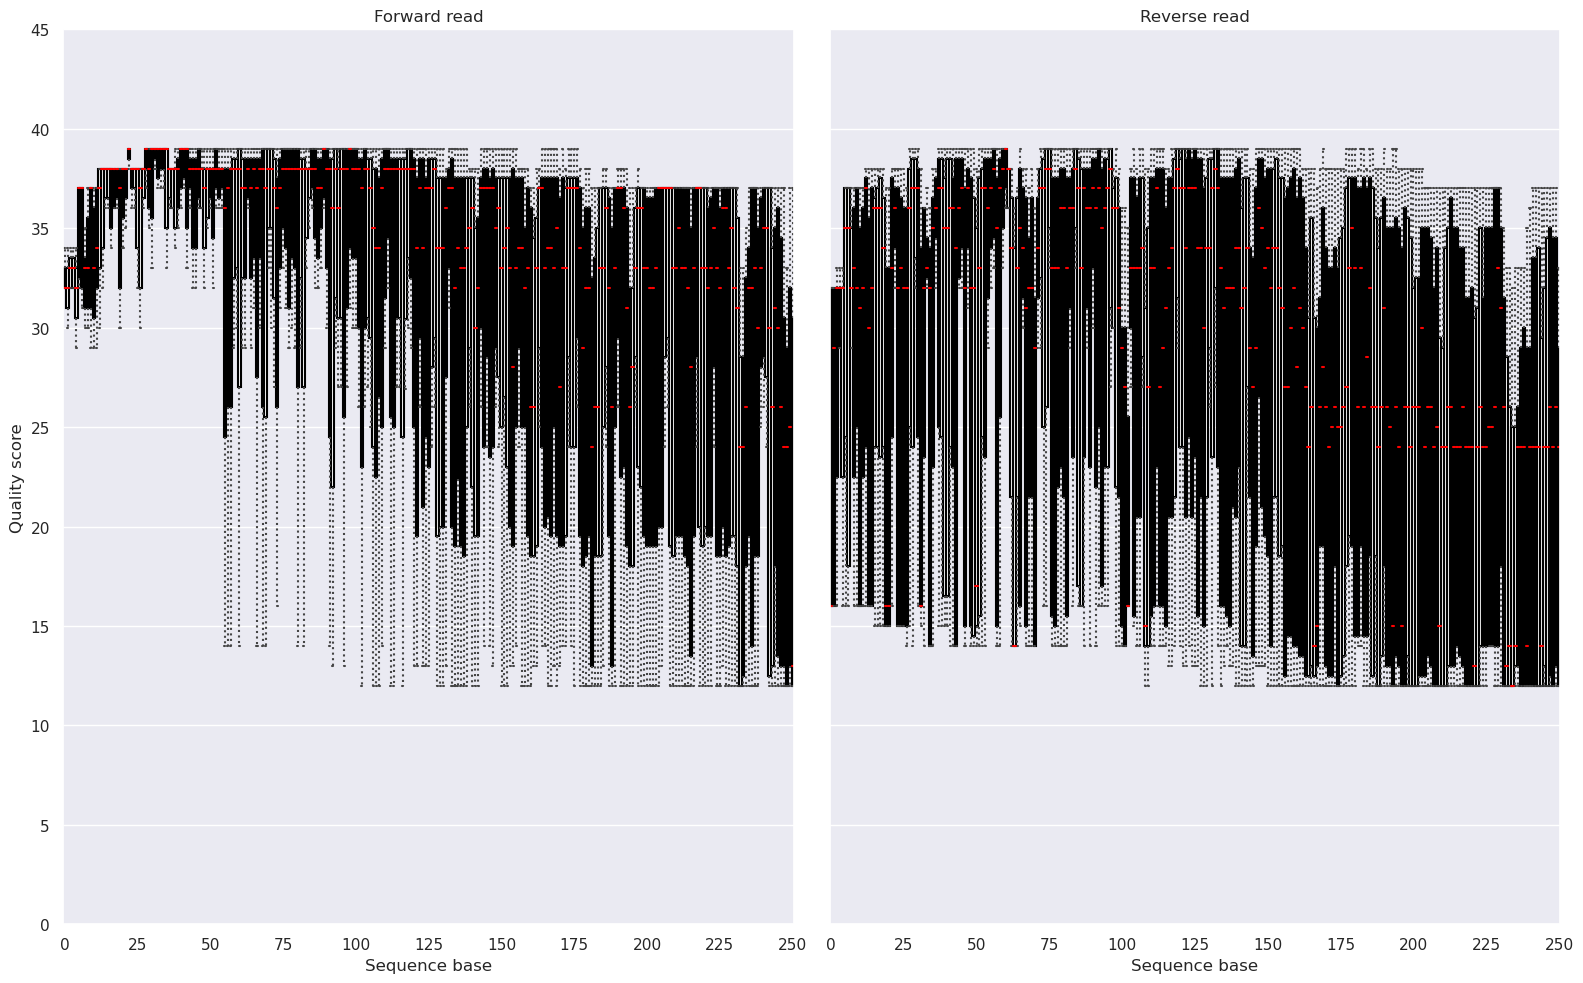

In [8]:
# Read quality visualization
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 10))
qzv_file = demux_viz
dokdo.read_quality_plot(qzv_file, strand='forward', ax=ax1)
dokdo.read_quality_plot(qzv_file, strand='reverse', ax=ax2)
ax1.set_title('Forward read')
ax2.set_title('Reverse read')
ax2.set_ylabel('')
ax2.set_yticklabels([])
ax2.autoscale(enable=True, axis='x', tight=False)
plt.tight_layout()

In [ ]:
### Denoising ###
# # If this gives a confusing error with a -9 exit code 
# # (meaning the process was stopped by the computer), it could be a memory issue.
# # Try increasing the RAM available to the cluster. 10 GB is a good place to start.
# # It seems like this (and maybe other) plugin(s) can't automatically detect the 
# # number of available cores, so that will have to be set automatically
table, rep_seqs, stats = qiime2.plugins.dada2.actions.denoise_paired(
    demultiplexed_seqs=trimmed_seqs,
    trim_left_f=5,
    trim_left_r=5,
    trunc_len_f=242,
    trunc_len_r=155,
    n_threads=n_cores,
)

# Denoising stats are summarized and saved below, along with
# FeatureTable[Frequency] (feature table) and FeatureData[Sequence] (representative sequences) artifacts.
stats_dada2_md_md = stats.view(qiime2.Metadata)

stats_viz, = qiime2.plugins.metadata.actions.tabulate(
    input=stats_dada2_md_md,
)
table_viz, = qiime2.plugins.feature_table.actions.summarize(
    table=table,
    sample_metadata=sample_metadata_md,
)
rep_seqs_viz, = qiime2.plugins.feature_table.actions.tabulate_seqs(
    data=rep_seqs,
)

In [10]:
### Denoising Stats ###
# This allows Interactive Qiime2 Visualizations (only temporary, hence the "sleepTime" argument)
# for viz in (stats_viz, table_viz, rep_seqs_viz):
#     q2Handler.qzvRender(viz, dimen=(1000, 1200), sleepTime=10)

<p>
    Analysis for the taxonomy section was performed using a python script in a HPC environment, but the code is also included
    here to increase reproducibility. This whole section is challenging to run on a jupyter notebook because all of the
    plugins involved tend to randomly crash. This is because they require a lot of RAM. Though a few tips for reducing RAM
    usage are give below, the safest option is to run the code from this cell in an environment with at least 64 Gb 
    of memory available. If the notebook fails, try running the code with sbatch in a Slurm script instead.
</p>

In [11]:
# ### Taxonomy Analysis ###
# ## Acquiring reference sequences and taxonomy for classifier training ##
# # Reads and taxonomy are downloaded from the silva database
# seqUrl = 'https://data.qiime2.org/2022.2/common/silva-138-99-seqs.qza'
# taxUrl = 'https://data.qiime2.org/2022.2/common/silva-138-99-tax.qza'

# seqFn = artifactDir.joinpath('silva-138-99-seqs.qza')
# taxFn = artifactDir.joinpath('silva-138-99-ref-tax.qza')

# urllib.request.urlretrieve(seqUrl, seqFn)
# urllib.request.urlretrieve(taxUrl, taxFn)
# silva_138_99_seq = qiime2.Artifact.load(seqFn)
# silva_138_99_tax = qiime2.Artifact.load(taxFn)

# ## Reads with the appropriate primers are extracted from the silva reads for classifier training ##
# forwardPrimer = 'GTGCCAGCMGCCGCGGTAA'
# reversePrimer = 'GGACTACHVGGGTWTCTAAT'

# # The min_length and max_length parameters can be used to exclude simulated amplicons that are far 
# # outside of the anticipated length distribution using these primers, but I didn't mess with those
# # here.
# silva_138_99_extracted = qiime2.plugins.feature_classifier.methods.extract_reads(
#     sequences = silva_138_99_seq,
#     f_primer = forwardPrimer,
#     r_primer = reversePrimer,
#     n_jobs = n_cores,
# )

# silva_138_99_ref_seqs = silva_138_99_extracted.reads

# # ## Classifier Training ##
# # Chunk size is 20000 by default. Try reducing that for the program not to crash
# nb_classifier = qiime2.plugins.feature_classifier.methods.fit_classifier_naive_bayes(
#     reference_reads=silva_138_99_ref_seqs,
#     reference_taxonomy=silva_138_99_tax,
# )

# fit_nb_classifier = nb_classifier.classifier

# ## Taxonomy Classification ##
# # For this one, you can't just set the n_jobs to be as high as possible. It has a lot of memory issues.
# # Apparently each job uses 4-8 gigs of ram, so it's easy to use more memory than is actually available.
# # If this happens, the classifier just refuses to continue, but doesn't throw an error, so the script
# # gets stuck in limbo. It's pretty fast with 64 gigs of RAM and 5 cores. It might be possible to use
# # a few more. If used in Jupyter, setting 'pre_dispatch' = '1' (string 1, not int 1) and reducing 'n_jobs' might help
# taxonomy, = qiime2.plugins.feature_classifier.actions.classify_sklearn(
#     classifier=fit_nb_classifier,
#     reads=rep_seqs,
#     n_jobs=(n_cores // 3),

# )

# taxonomy_as_md_md = taxonomy.view(qiime2.Metadata)
# taxonomy_viz, = qiime2.plugins.metadata.actions.tabulate(
#    input=taxonomy_as_md_md,
# )

# taxa_bar_plots_viz, = qiime2.plugins.taxa.actions.barplot(
#    table=table,
#    taxonomy=taxonomy,
#    metadata=sample_metadata_md,
# )

In [ ]:
## Filtering of feature table ##
# Features occuring in only one sample, or with a total abundance (across samples) < 10 are removed
cont_freq_filter = qiime2.plugins.feature_table.methods.filter_features(
    table=table,
    min_frequency=10,
    min_samples=2,
)
# Mitochondrial and chloroplast taxa, and taxa without genus-level annotation, are removed
mc_table_filter = qiime2.plugins.taxa.methods.filter_table(
    table=cont_freq_filter.filtered_table,
    taxonomy=taxonomy,
    exclude='mitochondria,chloroplast',
    include='g__'
)

# Samples with < 1000 total reads (1075 and 877 in this case) are removed.
sample_table_filter = qiime2.plugins.feature_table.methods.filter_samples(
    table=mc_table_filter.filtered_table,
    min_frequency=1000,
    filter_empty_features=True,
)

filtered_table = sample_table_filter.filtered_table

## Sequence Table Filtering ##
# The sequence table is filtered according to the filtered feature table
seq_filter = qiime2.plugins.feature_table.methods.filter_seqs(
    data=rep_seqs,
    table=filtered_table,
)

filtered_rep_seqs = seq_filter.filtered_data

## Taxonomy Filtering ##
taxonomy_df = taxonomy.view(pd.DataFrame)
filtered_table_df = filtered_table.view(pd.DataFrame)

filtered_taxonomy = qiime2.Artifact.import_data(
    type='FeatureData[Taxonomy]', 
    view=taxonomy_df[taxonomy_df.index.isin(filtered_table_df.transpose().index)]
)

## Visualization ##
filtered_table_viz, = qiime2.plugins.feature_table.actions.summarize(
    table=filtered_table,
    sample_metadata=sample_metadata_md,
)

filtered_rep_seqs_viz, = qiime2.plugins.feature_table.actions.tabulate_seqs(
    data=filtered_rep_seqs,
)

filtered_taxonomy_as_md_md = filtered_taxonomy.view(qiime2.Metadata)
filtered_taxonomy_viz, = qiime2.plugins.metadata.actions.tabulate(
   input=filtered_taxonomy_as_md_md,
)

filtered_taxa_bar_plots_viz, = qiime2.plugins.taxa.actions.barplot(
   table=filtered_table,
   taxonomy=filtered_taxonomy,
   metadata=sample_metadata_md,
)

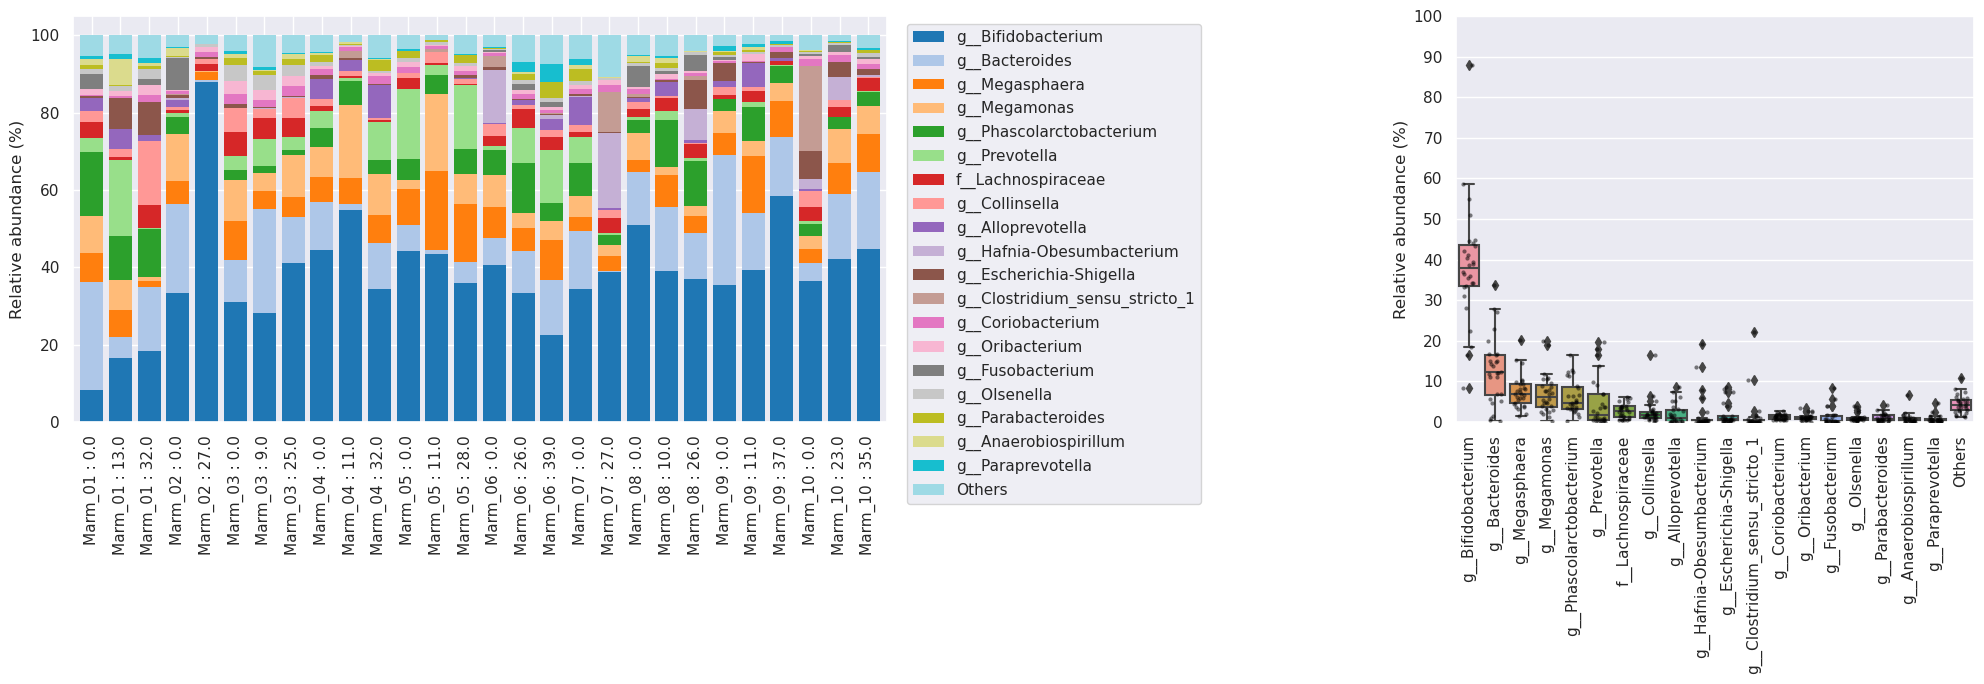

In [13]:
### Taxonomy Visualization ###
taxa_level = 6
filtered_samps = filtered_table.view(pd.DataFrame).index
samp_list = sampleMeta.loc[(sampleMeta.index.isin(filtered_samps)) & (sampleMeta['Condition'] != 'Stress')].index.astype(int).to_list()
loc = matplotlib.ticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals

## Taxonomy by sample name ##
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7), gridspec_kw={'width_ratios': [11, 1, 7]})
dokdo.taxa_abundance_bar_plot(
    taxa_bar_plots_viz,
    ax=ax1,
    level=taxa_level,
    sample_names=samp_list,
    label_columns=['Anon_Individual', 'Relative_Day'],
    count=20,
    cmap_name='tab20',
    legend=False
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plots_viz,
    ax=ax2,
    level=taxa_level,
    sample_names=samp_list,
    label_columns=['Anon_Individual', 'Relative_Day'],
    count=20,
    cmap_name='tab20',
    legend_short=True
)

handles, labels = ax2.get_legend_handles_labels()

ax2.clear()
ax2.legend(handles, labels)
ax2.axis('off')

dokdo.taxa_abundance_box_plot(
    taxa_bar_plots_viz,
    level=taxa_level,
    sample_names=samp_list,
    count=20,
    pretty_taxa=True,
    add_datapoints=True,
    alpha=0.5,
    jitter=0.25,
    size=3,
    ax=ax3
)
ax3.set_ylim(0, 100)
ax3.yaxis.set_major_locator(loc)
plt.tight_layout()

In [ ]:
### Phylogenetic Tree Creation ###
action_results = qiime2.plugins.phylogeny.actions.align_to_tree_mafft_fasttree(
    sequences=filtered_rep_seqs,
    n_threads=n_cores,
)
aligned_rep_seqs = action_results.alignment
masked_aligned_rep_seqs = action_results.masked_alignment
unrooted_tree = action_results.tree
rooted_tree = action_results.rooted_tree

### Core Diversity Metrics (Phylogenetic) ###
diversity_action_results = qiime2.plugins.diversity.actions.core_metrics_phylogenetic(
    phylogeny=rooted_tree,
    table=filtered_table,
    sampling_depth=2000,
    metadata=sample_metadata_md,
    n_jobs_or_threads=n_cores,
)

rarefied_table = diversity_action_results.rarefied_table
faith_pd_vector = diversity_action_results.faith_pd_vector
observed_features_vector = diversity_action_results.observed_features_vector
shannon_vector = diversity_action_results.shannon_vector
evenness_vector = diversity_action_results.evenness_vector
unweighted_unifrac_pcoa_results = diversity_action_results.unweighted_unifrac_pcoa_results
weighted_unifrac_pcoa_results = diversity_action_results.weighted_unifrac_pcoa_results
jaccard_pcoa_results = diversity_action_results.jaccard_pcoa_results
bray_curtis_pcoa_results = diversity_action_results.bray_curtis_pcoa_results
bray_curtis_distance = diversity_action_results.bray_curtis_distance_matrix

In [ ]:
### Saving Qiime2 Artifacts ###
# Artifacts can be saved immediately after they are generated. 
# All pre-processing artifacts are included in a single cell for convenience.

# Seqence trimming artifacts
paired_end_seqs.save(artifactDir.joinpath('paired-end-demux.qza').as_posix())
demux_viz.save(artifactDir.joinpath('paired-end-demux.qzv').as_posix())
trimmed_seqs.save(artifactDir.joinpath('trimmed-paired-end-demux.qza').as_posix())
trimmed_demux_viz.save(artifactDir.joinpath('trimmed-paired-end-demux.qzv').as_posix())

# Denoising and feature summary artifacts
table.save(artifactDir.joinpath('table.qza').as_posix())
rep_seqs.save(artifactDir.joinpath('rep-seqs.qza').as_posix())
stats.save(artifactDir.joinpath('denoising-stats.qza').as_posix())
stats_viz.save(artifactDir.joinpath('denoising-stats.qzv').as_posix())
table_viz.save(artifactDir.joinpath('table.qzv').as_posix())
rep_seqs_viz.save(artifactDir.joinpath('rep-seqs.qzv').as_posix())

# Taxonomy artifacts
silva_138_99_ref_seqs.save(artifactDir.joinpath('silva-138-99-extracted-ref-seqs.qza').as_posix())
fit_nb_classifier.save(artifactDir.joinpath('silva-138-99-fit-nb-classifier.qza').as_posix())
taxonomy.save(artifactDir.joinpath('taxonomy.qza').as_posix())
taxonomy_viz.save(artifactDir.joinpath('taxonomy.qzv').as_posix())
taxa_bar_plots_viz.save(artifactDir.joinpath('taxa-bar-plots.qzv').as_posix())

# Filtering artifacts
filtered_table.save(artifactDir.joinpath('filtered-table.qza').as_posix())
filtered_rep_seqs.save(artifactDir.joinpath('filtered-rep-seqs.qza').as_posix())
filtered_taxonomy.save(artifactDir.joinpath('filtered-taxonomy.qza').as_posix())
filtered_taxonomy_viz.save(artifactDir.joinpath('filtered-taxonomy.qzv').as_posix())
filtered_rep_seqs_viz.save(artifactDir.joinpath('filtered-rep-seqs.qzv').as_posix())
filtered_table_viz.save(artifactDir.joinpath('filtered-table.qzv').as_posix())
filtered_taxonomy_viz.save(artifactDir.joinpath('filtered-taxa-bar-plots.qzv').as_posix())

# Phylogenetic tree and diversity artifacts
aligned_rep_seqs.save(artifactDir.joinpath('alignment.qza').as_posix())
masked_aligned_rep_seqs.save(artifactDir.joinpath('masked_alignment.qza').as_posix())
unrooted_tree.save(artifactDir.joinpath('tree.qza').as_posix())
rooted_tree.save(artifactDir.joinpath('rooted_tree.qza').as_posix())
rarefied_table.save(artifactDir.joinpath('rarefied-table.qza').as_posix())
faith_pd_vector.save(artifactDir.joinpath('faith_pd_vector.qza').as_posix())
observed_features_vector.save(artifactDir.joinpath('observed_features_vector.qza').as_posix())
shannon_vector.save(artifactDir.joinpath('shannon_vector.qza').as_posix())
evenness_vector.save(artifactDir.joinpath('evenness_vector.qza').as_posix())
unweighted_unifrac_pcoa_results.save(artifactDir.joinpath('unweighted_unifrac_pcoa_results.qza').as_posix())
weighted_unifrac_pcoa_results.save(artifactDir.joinpath('weighted_unifrac_pcoa_results.qza').as_posix())
jaccard_pcoa_results.save(artifactDir.joinpath('jaccard_pcoa_results.qza').as_posix())
bray_curtis_pcoa_results.save(artifactDir.joinpath('bray_curtis_pcoa_results.qza').as_posix())
bray_curtis_distance.save(artifactDir.joinpath('bray_curtis_distance_matrix.qza').as_posix())

In [16]:
### Importing Qiime2 Artifacts ###
# Similarly, artifacts can be imported here instead of re-runinng the entire pipeline. 
# All pre-processing artifacts are included in a single cell for convenience.

# Seqence trimming artifacts
paired_end_seqs = qiime2.Artifact.load(artifactDir.joinpath('paired-end-demux.qza'))
demux_viz = qiime2.Visualization.load(artifactDir.joinpath('paired-end-demux.qzv'))
trimmed_seqs = qiime2.Artifact.load(artifactDir.joinpath('trimmed-paired-end-demux.qza'))
trimmed_demux_viz = qiime2.Visualization.load(artifactDir.joinpath('trimmed-paired-end-demux.qzv'))

# Denoising and feature summary artifacts
table = qiime2.Artifact.load(artifactDir.joinpath('table.qza'))
rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('rep-seqs.qza'))
stats = qiime2.Artifact.load(artifactDir.joinpath('denoising-stats.qza'))
stats_viz = qiime2.Visualization.load(artifactDir.joinpath('denoising-stats.qzv'))
table_viz = qiime2.Visualization.load(artifactDir.joinpath('table.qzv'))
rep_seqs_viz = qiime2.Visualization.load(artifactDir.joinpath('rep-seqs.qzv'))

# Taxonomy artifacts
silva_138_99_ref_seqs = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-extracted-ref-seqs.qza'))
fit_nb_classifier = qiime2.Artifact.load(artifactDir.joinpath('silva-138-99-fit-nb-classifier.qza'))
taxonomy = qiime2.Artifact.load(artifactDir.joinpath('taxonomy.qza'))
taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('taxonomy.qzv'))
taxa_bar_plots_viz = qiime2.Visualization.load(artifactDir.joinpath('taxa-bar-plots.qzv'))

# Filtering artifacts
filtered_table = qiime2.Artifact.load(artifactDir.joinpath('filtered-table.qza'))
filtered_rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('filtered-rep-seqs.qza'))
filtered_taxonomy = qiime2.Artifact.load(artifactDir.joinpath('filtered-taxonomy.qza'))
filtered_taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-taxonomy.qzv'))
filtered_rep_seqs_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-rep-seqs.qzv'))
filtered_table_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-table.qzv'))
filtered_taxonomy_viz = qiime2.Visualization.load(artifactDir.joinpath('filtered-taxa-bar-plots.qzv'))

# Phylogenetic tree and diversity artifacts
aligned_rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('alignment.qza'))
masked_aligned_rep_seqs = qiime2.Artifact.load(artifactDir.joinpath('masked_alignment.qza'))
unrooted_tree = qiime2.Artifact.load(artifactDir.joinpath('tree.qza'))
rooted_tree = qiime2.Artifact.load(artifactDir.joinpath('rooted_tree.qza'))
rarefied_table = qiime2.Artifact.load(artifactDir.joinpath('rarefied-table.qza'))
faith_pd_vector = qiime2.Artifact.load(artifactDir.joinpath('faith_pd_vector.qza'))
observed_features_vector = qiime2.Artifact.load(artifactDir.joinpath('observed_features_vector.qza'))
shannon_vector = qiime2.Artifact.load(artifactDir.joinpath('shannon_vector.qza'))
evenness_vector = qiime2.Artifact.load(artifactDir.joinpath('evenness_vector.qza'))
unweighted_unifrac_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('unweighted_unifrac_pcoa_results.qza'))
weighted_unifrac_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('weighted_unifrac_pcoa_results.qza'))
jaccard_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('jaccard_pcoa_results.qza'))
bray_curtis_pcoa_results = qiime2.Artifact.load(artifactDir.joinpath('bray_curtis_pcoa_results.qza'))
bray_curtis_distance = qiime2.Artifact.load(artifactDir.joinpath('bray_curtis_distance_matrix.qza'))

In [17]:
# Taxa are collapsed to relative genera abundance
collapsedTaxa = q2Handler.collapseTaxa(tableFile=artifactDir.joinpath('filtered-table.qza').as_posix(), taxonomyFile=artifactDir.joinpath('taxonomy.qza').as_posix())
genera_relative_abundance_table, = qiime2.plugins.feature_table.actions.relative_frequency(
    table=collapsedTaxa['level_6']
)

relativeGenera = genera_relative_abundance_table.view(pd.DataFrame).reset_index().rename(columns={'index': 'Sample_ID'})

# Missing samples in the filtered relativeGenera and relativeSpecies tables are replaced with 0
missingSamps = pd.Series(sampleMeta.loc[~sampleMeta.index.isin(relativeGenera['Sample_ID'])].index.values)
relativeGenera = pd.concat([relativeGenera, pd.DataFrame(np.full((len(missingSamps), len(relativeGenera.columns)), 0), columns=relativeGenera.columns)])
relativeGenera['Sample_ID'] = pd.concat((relativeGenera['Sample_ID'][:-len(missingSamps)], missingSamps))

# # The sample order in relativeGenera is matched to the sample metadata file
relativeGenera = relativeGenera.set_index('Sample_ID').loc[sampleMeta.index]

relativeGenera.to_csv(manifestDir.joinpath('filtered_16s_relative_genera_abundance.tsv'), index=True, na_rep='NaN', sep='\t')

<h3>Metabolomics processing and filtering</h3>
<p>Metabolomics data are read, cross-checked to the PubChem database, filtered, and scaled.</p>

In [18]:
### Metabolomics ###
# Dictionary mapping the column names of the targeted datasets to inchikey
metabColNameToInchikey = { 'αMA (ng/g)': 'DKPMWHFRUGMUKF-GDYCBZMLSA-N', 'βMA (ng/g)': 'DKPMWHFRUGMUKF-CRKPLTDNSA-N',
    'βMA ': 'DKPMWHFRUGMUKF-CRKPLTDNSA-N', 'ΩMA': 'DKPMWHFRUGMUKF-NTPBNISXSA-N', 'ΩMA ': 'DKPMWHFRUGMUKF-NTPBNISXSA-N',
    'CA (ng/g)': 'BHQCQFFYRZLCQQ-OELDTZBJSA-N', 'HCA (ng/g)': 'DKPMWHFRUGMUKF-KWXDGCAGSA-N', 'LCA (µg/g)': 'SMEROWZSTRWXGI-HVATVPOCSA-N',
    'CDCA (µg/g)': 'RUDATBOHQWOJDD-BSWAIDMHSA-N', 'DCA (µg/g)': 'KXGVEGMKQFWNSR-LLQZFEROSA-N', 'GCA (ng/g)': 'RFDAIACWWDREDC-FRVQLJSFSA-N',
    'GCDCA (ng/g)': 'GHCZAUBVMUEKKP-GYPHWSFCSA-N', 'GDCA (ng/g)': 'WVULKSPCQVQLCU-BUXLTGKBSA-N', 'GLCA (ng/g)': 'XBSQTYHEGZTYJE-OETIFKLTSA-N',
    'TCA (ng/g)': 'WBWWGRHZICKQGZ-HZAMXZRMSA-N', 'TCDCA (ng/g)': 'BHTRKEVKTKCXOH-BJLOMENOSA-N', 'TLCA (ng/g)': 'QBYUNVOYXHFVKC-GBURMNQMSA-N',
    'TDCA (ng/g)': 'AWDRATDZQPNJFN-VAYUFCLWSA-N', 'HyPro': 'PMMYEEVYMWASQN-DMTCNVIQSA-N', 'His': 'HNDVDQJCIGZPNO-YFKPBYRVSA-N',
    'Asn': 'DCXYFEDJOCDNAF-REOHCLBHSA-N', 'Tau': 'XOAAWQZATWQOTB-UHFFFAOYSA-N', 'Ser': 'MTCFGRXMJLQNBG-REOHCLBHSA-N',
    'Gln': 'ZDXPYRJPNDTMRX-VKHMYHEASA-N', 'Arg': 'ODKSFYDXXFIFQN-BYPYZUCNSA-N', 'Gly': 'DHMQDGOQFOQNFH-UHFFFAOYSA-N',
    'Asp': 'CKLJMWTZIZZHCS-REOHCLBHSA-N', 'Thr': 'AYFVYJQAPQTCCC-GBXIJSLDSA-N', 'Ala': 'QNAYBMKLOCPYGJ-REOHCLBHSA-N', 
    'GABA': 'BTCSSZJGUNDROE-UHFFFAOYSA-N', 'Pro': 'ONIBWKKTOPOVIA-BYPYZUCNSA-N', 'Orn': 'AHLPHDHHMVZTML-BYPYZUCNSA-N',
    'Cys': 'XUJNEKJLAYXESH-REOHCLBHSA-N', 'Cys2': 'LEVWYRKDKASIDU-IMJSIDKUSA-N', 'Lys': 'KDXKERNSBIXSRK-YFKPBYRVSA-N',
    'Tyr': 'OUYCCCASQSFEME-QMMMGPOBSA-N', 'Met': 'FFEARJCKVFRZRR-BYPYZUCNSA-N', 'Val': 'KZSNJWFQEVHDMF-BYPYZUCNSA-N', 
    'Ile': 'AGPKZVBTJJNPAG-WHFBIAKZSA-N', 'Leu': 'ROHFNLRQFUQHCH-YFKPBYRVSA-N', 'Phe': 'COLNVLDHVKWLRT-QMMMGPOBSA-N',
    'Trp': 'QIVBCDIJIAJPQS-VIFPVBQESA-N', 'Glu': 'WHUUTDBJXJRKMK-VKHMYHEASA-N', 'Acetic acid': 'QTBSBXVTEAMEQO-UHFFFAOYSA-N', 
    'Propionic acid': 'XBDQKXXYIPTUBI-UHFFFAOYSA-N', 'Butyric acid': 'FERIUCNNQQJTOY-UHFFFAOYSA-N',
    'Isovaleric acid': 'GWYFCOCPABKNJV-UHFFFAOYSA-N', 'Valeric acid': 'NQPDZGIKBAWPEJ-UHFFFAOYSA-N'
}

# Dictionaries mapping the inchikey to a tuple with: 
#the PubChem CID (0), common name (1), and molecular formula (2)
metabInchikeyToProperties = {}
# Initial data and metadata are read. The scfa columns measured in "Concentration in µmol/g" are dropped, as they are also measured in mg/g
bileAcids = pd.DataFrame(pd.read_excel(metabFileDir.joinpath('SH_BileAcid_Report_20210222.xlsx'), engine='openpyxl'))
faa = pd.DataFrame(pd.read_excel(metabFileDir.joinpath('SH_FAA_Report_20210114.xlsx'), engine='openpyxl')).iloc[:-2, :27]
scfa = pd.DataFrame(pd.read_excel(metabFileDir.joinpath('SH_SCFAs_Report_20210706_Corrected_20220128.xlsx'), engine='openpyxl', header=1)).iloc[:, :5]

# Duplicate metabolites are removed from the faa dataset according to collaborator's input
faa = faa.drop(columns='Tyr').rename(columns={'Tyr.1': 'Tyr'})

In [19]:
# PUG REST is used to query the common metabolite names and save the inchikeys.
prolog = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/'
inputs = '/compound/inchikey/'
operation = '/property/inchikey,title,molecularformula,iupacname'
output = '/JSON'
headers = {
    'Content-Type': "application/x-www-form-urlencoded",
}
# Inchikeys from all datasets are combined and queried against the PubChem database
payload = {'inchikey': ','.join(list(metabColNameToInchikey.values()))}

response = requests.request(
    method='POST', 
    url=prolog + inputs + operation + output,
    data=payload,
    headers=headers
)
# Results are written to the metabInchikeyToProperties dict
for record in response.json()['PropertyTable']['Properties']:
    metabInchikeyToProperties.update({record['InChIKey']: [str(record['CID']), record['Title'], record['MolecularFormula'], record['IUPACName']]})

In [ ]:
### Metabolite and Taxonomy Processing ###
## Columns are renamed to allow easier indexing
for df in (bileAcids, faa, scfa):
    df.rename(columns={df.columns[0] : 'Sample_ID'}, inplace=True)
    df.rename(columns=metabColNameToInchikey, inplace=True)
    df['Sample_ID'] = df['Sample_ID'].astype(int)
    

# As the targeted metabolites are quantified in different units, they are converted to a common unit (ug/g)
scfa.iloc[:, 1:] = scfa.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') * 1000
ngCols = bileAcids.loc[:, ~bileAcids.columns.isin(['SMEROWZSTRWXGI-HVATVPOCSA-N','RUDATBOHQWOJDD-BSWAIDMHSA-N','KXGVEGMKQFWNSR-LLQZFEROSA-N'])].copy()
ngCols.iloc[:, 1:] = ngCols.iloc[:, 1:].apply(pd.to_numeric, errors='coerce') / 1000
bileAcids.loc[:, bileAcids.columns.isin(ngCols.columns)] = ngCols

# Metabolites are combined into one dataframe
targetedMetab = scfa.merge(bileAcids, on='Sample_ID').merge(faa, on='Sample_ID').replace(('ND', 0.0), np.NaN)
targetedMetab['Sample_ID'] = targetedMetab['Sample_ID'].astype(str)

# Targeted feature metadata is created
targetedFeatureMeta = {'INCHIKEY': [], 'CID': [], 'Metabolite name': [], 'Formula': [], 'IUPACName': [], 'Method': [], 'Dataset': []}
for tup in ((scfa.columns[1:], 'GC-MS', 'short_chain_fatty_acids'), (bileAcids.columns[1:], 'LC-MS', 'bile_acids'), (faa.columns[1:], 'HPLC', 'amino_acids')):
    for key, value in ((col, metabInchikeyToProperties.get(col)) for col in tup[0]):
        targetedFeatureMeta['INCHIKEY'].append(key)
        targetedFeatureMeta['CID'].append(value[0])
        targetedFeatureMeta['Metabolite name'].append(value[1])
        targetedFeatureMeta['Formula'].append(value[2])
        targetedFeatureMeta['IUPACName'].append(value[3])
        targetedFeatureMeta['Method'].append(tup[1])
        targetedFeatureMeta['Dataset'].append(tup[2])
targetedFeatureMeta = pd.DataFrame(targetedFeatureMeta).T.reset_index()
targetedFeatureMeta.columns = np.concatenate([['Sample_ID'], targetedFeatureMeta.iloc[0, 1:].values])

# The sample_id column is used as a uniting index for all of the dataframes
for df in (targetedMetab, targetedFeatureMeta):
    df.set_index('Sample_ID', inplace=True)

# The samples are reordered in each dataframe to match the order in the sample metadata
targetedMetab = targetedMetab.loc[sampleMeta.index, :]

In [21]:
### Filtering and Feature Scaling ###
# Features with more than 70% missing values are dropped, and remaining missing values are replaced with the median
targetedMetab.drop(columns=targetedMetab.loc[:, (targetedMetab.isna().sum() / targetedMetab.shape[0]) > .70].columns, inplace=True)

# Metabolite datasets are scaled by the median so that each feature has a median of 1.
# Scaled metabolites are used for all subsequent linear modeling and correlation steps,
# while unscaled metabolites are normalized within method later and used for ordination steps (i.e., PCoA and PERMANOVA)
metabScaled = (targetedMetab.fillna(targetedMetab.median(), axis=0) / targetedMetab.median(axis=0)).dropna(axis=1)

# Metabolite metadata is updated to remove dropped metabolites
targetedFeatureMeta = targetedFeatureMeta[metabScaled.columns]

# Processed metabolite metadata and abundance are written to output files
targetedFeatureMeta.to_csv(manifestDir.joinpath('processed_metabolite_feature_metadata.tsv'), sep='\t', index=True)
targetedMetab.to_csv(manifestDir.joinpath('processed_metabolite_abundance.tsv'), sep='\t', index=True)

<h3>Statistical analysis by treatment condition</h3>
<p>A multitude of statistical tests are performed to identify differences in the microbiome and metabolome as a result of treatment condition. Stress samples are removed for the remainder of the analysis.</p>

In [ ]:
### Alpha and Beta Significance Testing ###
# As these were tested in Qiime2, relevant tsv files can be obtained by uploading these qzv files to their website
alpha_significance_faith_pd, = qiime2.plugins.diversity.visualizers.alpha_group_significance(
    alpha_diversity=faith_pd_vector,
    metadata=sample_metadata_md,
)

beta_significance_bray_curtis, = qiime2.plugins.diversity.visualizers.beta_group_significance(
    distance_matrix=bray_curtis_distance,
    metadata=sample_metadata_md.get_column('Condition'),
    pairwise=True,
    method='permanova'
)
beta_significance_bray_curtis.save(artifactDir.joinpath('beta-significance-bray-curtis.qzv').as_posix())
alpha_significance_faith_pd.save(artifactDir.joinpath('alpha-significance-faith-pd.qzv').as_posix())

# for viz in (alpha_significance_faith_pd, beta_significance_bray_curtis):
    # q2Handler.qzvRender(viz, dimen=(1000, 600), sleepTime=10)  

In [23]:
### Lefse ###
lefseDir = analysisDir.joinpath('16S/lefse')

if not lefseDir.exists():
    lefseDir.mkdir()
    
# A lefse-formatted tsv file is created
sampleMeta[['Condition']].join(relativeGenera).T.to_csv(lefseDir.joinpath('relative_genera_lefse_format.tsv'), index=True, na_rep='NaN', sep='\t', index_label='Sample_ID')

In [24]:
%%bash -s "$analysisDir/16S/lefse"
lefseDir=$1
lefse_format_input.py "${lefseDir}/relative_genera_lefse_format.tsv" "${lefseDir}/relative_genera_lefse.in" -c 2 -u 1
lefse_run.py "${lefseDir}/relative_genera_lefse.in" "${lefseDir}/relative_genera_lefse.res"
# This is empty because lefse reports no differentially abundant features
lefse_plot_res.py "${lefseDir}/relative_genera_lefse.res" "${lefseDir}/relative_genera_lefse.png"

Number of significantly discriminative features: 1 ( 1 ) before internal wilcoxon
Number of discriminative features with abs LDA score > 2.0 : 0
No differentially abundant features found in /work/claytonlab/jhernandez/projects/temp_marm_microbiome/analysis/16S/lefse/relative_genera_lefse.res


In [25]:
%%R -i figurePath,sampleMeta,metabScaled,relativeGenera,targetedFeatureMeta -o metabRes -w 1000 -h 500

sampleMeta$Relative_Day <- as.integer(sampleMeta$Relative_Day)

# Dataframes are concatenated with appropriate metadata
targMetabDat <- convertDF(metabScaled, sampleMeta)
relGeneraDat <- convertDF(relativeGenera, sampleMeta)
targMetabDat$metaF <- targetedFeatureMeta

# Metabolomics data is normalized within method
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0

for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

# Microbiome data is row-sum normalized (doesn't make much difference as the data are already relative abundance data)
# and samples with all zeroes are dropped
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
genSums[genSums == 0] <- 1
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums
relGeneraDat.nrm$x <- relGeneraDat.nrm$x[rowSums(relGeneraDat.nrm$x) > 0,]
relGeneraDat.nrm$metaS <- relGeneraDat.nrm$metaS[rownames(relGeneraDat.nrm$x),]

# A transformation is applied to the data to reduce the effect of outliers and increase linearity.
# Metabolomics data is log2(x + 1) transformed, and microbiome data is arcsine square-root transformed.
targMetabDat.trans <- targMetabDat
targMetabDat.trans$x <- log2(targMetabDat.trans$x + 1)
relGeneraDat.trans <- relGeneraDat
relGeneraDat.trans$x <- asin(sqrt(relGeneraDat.trans$x))

# PERMANOVA is run for metabolomics and genera abundance data. Zeros are used for filtered samples (n=2)
# because PERMANOVA required a balanced number of samples
generaPermStress <- runPermStress(relGeneraDat)
metabPermStress <- runPermStress(targMetabDat.nrm)
print(generaPermStress)
print(metabPermStress)

# Metabolites are fitted to a mixed model and their p-values/log2 fold changes are extracted
metabRes <- runMixedModel(targMetabDat.trans)

R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.6-4

R[write to console]: Loading required package: mgcv

R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

R[write to console]: This is labdsv 2.0-1
convert existing ordinations with as.dsvord()

R[write to console]: 
Attaching package: ‘labdsv’


R[write to console]: The following object is masked from ‘package:stats’:

    density




[[1]]
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Plots: df$metaS$Individual, plot permutation: free
Permutation: none
Number of permutations: 9999

adonis2(formula = D ~ Sex + Cage + Individual, data = df$metaS, permutations = bet_perm)
           Df SumOfSqs      R2      F Pr(>F)
Sex         1   0.2612 0.05573 2.5309 0.1814
Cage        6   1.0382 0.22153 1.6766 0.6707
Individual  3   0.3943 0.08413 1.2735 0.7417
Residual   29   2.9929 0.63861              
Total      39   4.6867 1.00000              

[[2]]
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Plots: df$metaS$Individual, plot permutation: none
Permutation: free
Number of permutations: 9999

adonis2(formula = D ~ Individual + Condition, data = df$metaS, permutations = within_perm)
           Df SumOfSqs      R2      F Pr(>F)
Individual  9   1.6578 0.35374 1.9073 0.1383
Condition   3   0.4212 0.08987 1.4537 0.1383
Residual   27   2.6076 0.5

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lme4’


R[write to console]: The following object is masked from ‘package:labdsv’:

    factorize


R[write to console]: The following object is masked from ‘package:nlme’:

    lmList


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [26]:
# Samples that were exposed to a stressful stimulus are removed from this analysis
sampleMetaNoStress = sampleMeta[sampleMeta['Condition'] != 'Stress']
metabScaledNoStress = metabScaled.loc[sampleMetaNoStress.index, :]
relativeGeneraNoStress = relativeGenera.loc[sampleMetaNoStress.index, :]

# Significant metabolites are written to an external file to be compiled later
metabRes = dict(metabRes)
metabSig = metabRes['sig']
metabResid = metabRes['res']

sigMetab = metabSig.loc[(metabSig.iloc[:, -3:] <= 0.05).any(axis=1)]
sigMetab = sigMetab.join(targetedFeatureMeta.T[['INCHIKEY', 'CID', 'Metabolite name']])
sigMetab = pd.concat([sigMetab.iloc[:, -3:], sigMetab.iloc[:, :-3]], axis=1)
display(sigMetab)

sigMetabDir = analysisDir.joinpath('metabolomics')
if not sigMetabDir.exists():
    sigMetabDir.mkdir()
    
sigMetab.to_csv(sigMetabDir.joinpath('significant_metabolites_by_condition_raw.tsv'), sep='\t', index=False)

INCHIKEY      CID  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N  DKPMWHFRUGMUKF-GDYCBZMLSA-N  5283852   
RFDAIACWWDREDC-FRVQLJSFSA-N  RFDAIACWWDREDC-FRVQLJSFSA-N    10140   
GHCZAUBVMUEKKP-GYPHWSFCSA-N  GHCZAUBVMUEKKP-GYPHWSFCSA-N    12544   
WVULKSPCQVQLCU-BUXLTGKBSA-N  WVULKSPCQVQLCU-BUXLTGKBSA-N  3035026   
WBWWGRHZICKQGZ-HZAMXZRMSA-N  WBWWGRHZICKQGZ-HZAMXZRMSA-N     6675   
AWDRATDZQPNJFN-VAYUFCLWSA-N  AWDRATDZQPNJFN-VAYUFCLWSA-N  2733768   
XOAAWQZATWQOTB-UHFFFAOYSA-N  XOAAWQZATWQOTB-UHFFFAOYSA-N     1123   
AYFVYJQAPQTCCC-GBXIJSLDSA-N  AYFVYJQAPQTCCC-GBXIJSLDSA-N     6288   
KDXKERNSBIXSRK-YFKPBYRVSA-N  KDXKERNSBIXSRK-YFKPBYRVSA-N     5962   

                                        Metabolite name  pvaluePre  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N       alpha-Muricholic acid   0.003532   
RFDAIACWWDREDC-FRVQLJSFSA-N            Glycocholic acid   0.000598   
GHCZAUBVMUEKKP-GYPHWSFCSA-N  Glycochenodeoxycholic acid   0.001239   
WVULKSPCQVQLCU-BUXLTGKBSA-N       Glycodeoxycholic acid   0.007678   
WBWWGRHZICKQGZ-HZAMXZRMSA-N            Taurocholic acid   0.003550   
AWDRATDZQPNJFN-VAYUFCLWSA-N       Taurodeoxycholic acid   0.008516   
XOAAWQZATWQOTB-UHFFFAOYSA-N                     Taurine   0.005837   
AYFVYJQAPQTCCC-GBXIJSLDSA-N                   Threonine   0.003945   
KDXKERNSBIXSRK-YFKPBYRVSA-N                      Lysine   0.008076   

                             pvalueStress  pvaluePost  log2FCPre  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N      0.010610    0.004435  -0.718026   
RFDAIACWWDREDC-FRVQLJSFSA-N      0.001666    0.001378  -1.118967   
GHCZAUBVMUEKKP-GYPHWSFCSA-N      0.004485    0.007679  -0.795141   
WVULKSPCQVQLCU-BUXLTGKBSA-N      0.000785    0.016133  -0.556565   
WBWWGRHZICKQGZ-HZAMXZRMSA-N      0.017588    0.016781  -2.690550   
AWDRATDZQPNJFN-VAYUFCLWSA-N      0.030180    0.035892  -2.005430   
XOAAWQZATWQOTB-UHFFFAOYSA-N      0.132548    0.203712  -1.967654   
AYFVYJQAPQTCCC-GBXIJSLDSA-N      0.075900    0.174158   0.296367   
KDXKERNSBIXSRK-YFKPBYRVSA-N      0.571170    0.599211   0.446705   

                             log2FCStress  log2FCPost  qvaluePre  \
DKPMWHFRUGMUKF-GDYCBZMLSA-N     -0.619685   -0.698186   0.030769   
RFDAIACWWDREDC-FRVQLJSFSA-N     -1.005662   -1.026889   0.023326   
GHCZAUBVMUEKKP-GYPHWSFCSA-N     -0.683440   -0.635024   0.024154   
WVULKSPCQVQLCU-BUXLTGKBSA-N     -0.730746   -0.495840   0.036901   
WBWWGRHZICKQGZ-HZAMXZRMSA-N     -2.130208   -2.147440   0.030769   
AWDRATDZQPNJFN-VAYUFCLWSA-N     -1.625303   -1.569692   0.036901   
XOAAWQZATWQOTB-UHFFFAOYSA-N     -1.019457   -0.856194   0.036901   
AYFVYJQAPQTCCC-GBXIJSLDSA-N      0.173556    0.131234   0.030769   
KDXKERNSBIXSRK-YFKPBYRVSA-N      0.089549    0.083064   0.036901   

                             qvalueStress  qvaluePost  
DKPMWHFRUGMUKF-GDYCBZMLSA-N      0.068968    0.057659  
RFDAIACWWDREDC-FRVQLJSFSA-N      0.032481    0.053724  
GHCZAUBVMUEKKP-GYPHWSFCSA-N      0.058307    0.063048  
WVULKSPCQVQLCU-BUXLTGKBSA-N      0.030598    0.081806  
WBWWGRHZICKQGZ-HZAMXZRMSA-N      0.085739    0.081806  
AWDRATDZQPNJFN-VAYUFCLWSA-N      0.130778    0.152182  
XOAAWQZATWQOTB-UHFFFAOYSA-N      0.304080    0.397238  
AYFVYJQAPQTCCC-GBXIJSLDSA-N      0.227699    0.357481  
KDXKERNSBIXSRK-YFKPBYRVSA-N      0.708249    0.736478

<h3>Follow-up statistical analysis and extraction of residuals</h3>
<p>Subsequent statistical testing is performed following removal of stress samples. Microbiome and metabolome data are fitted to a linear model, after which residuals are extracted.</p>

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[[1]]
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Plots: df$metaS$Individual, plot permutation: free
Permutation: none
Number of permutations: 9999

adonis2(formula = D ~ Sex + Cage + Individual, data = df$metaS, permutations = bet_perm)
           Df SumOfSqs      R2      F Pr(>F)
Sex         1   0.2095 0.05677 1.7942 0.2977
Cage        6   0.8994 0.24374 1.2840 0.6318
Individual  3   0.3630 0.09837 1.0364 0.7113
Residual   19   2.2181 0.60112              
Total      29   3.6899 1.00000              

[[2]]
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Plots: df$metaS$Individual, plot permutation: none
Permutation: free
Number of permutations: 9999

adonis2(formula = D ~ Individual + Relativ

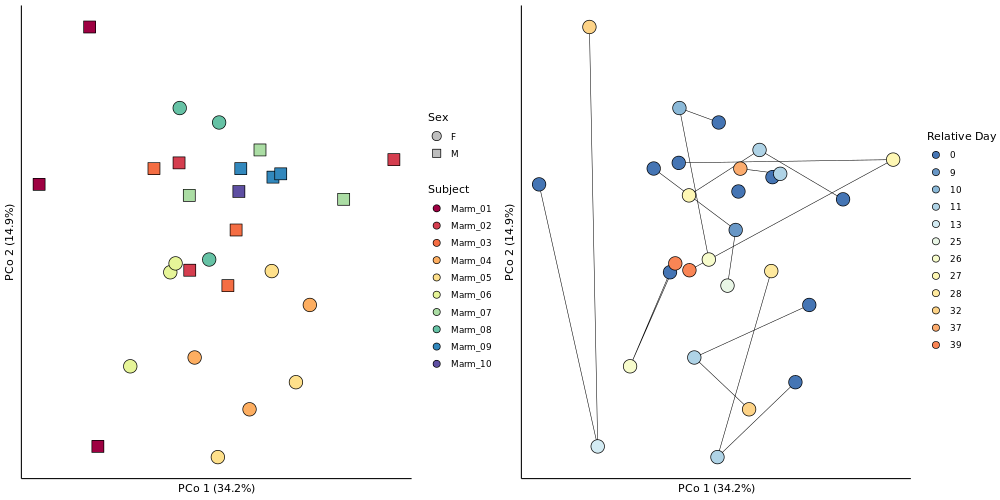

In [27]:
%%R -i figurePath,sampleMetaNoStress,metabScaledNoStress,relativeGeneraNoStress,targetedFeatureMeta -o targMetabRes,relGeneraRes -w 1000 -h 500
### Ordination ###
sampleMetaNoStress$Relative_Day <- as.integer(sampleMetaNoStress$Relative_Day)

# Dataframes are concatenated with appropriate metadata
targMetabDat <- convertDF(metabScaledNoStress, sampleMetaNoStress)
relGeneraDat <- convertDF(relativeGeneraNoStress, sampleMetaNoStress)
targMetabDat$metaF <- targetedFeatureMeta

# Metabolomics data is normalized within method
targMetabDat.nrm <- targMetabDat
imputed <- apply(targMetabDat$x, 2, median)
nfixed <- 0
for (i in seq_along(rownames(targMetabDat.nrm$x))) {
    prf <- targMetabDat.nrm$x[i,]
    nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
    outlier <- nprf > 0.5
    
    # Outliers are replaced with the median and normalized again
    while (any(outlier)) {
        nfixed <- nfixed + sum(outlier)
        prf[outlier] <- imputed[outlier]
        nprf <- prf / ave(as.numeric(prf), list(as.character(targMetabDat$metaF["Method",])), FUN=sum)
        outlier <- nprf > 0.5
    }
    targMetabDat.nrm$x[i,] <- nprf
}

# Microbiome data is row-sum normalized and samples with all zeroes are dropped
relGeneraDat.nrm <- relGeneraDat
genSums <- rowSums(relGeneraDat.nrm$x)
genSums[genSums == 0] <- 1
relGeneraDat.nrm$x <- relGeneraDat.nrm$x / genSums
relGeneraDat.nrm$x <- relGeneraDat.nrm$x[rowSums(relGeneraDat.nrm$x) > 0,]

# Bray-Curtis distance matrix is calculated and a PCoA plot is created
metabPCoA <- PCoA(targMetabDat.nrm)
generaPCoA <- PCoA(relGeneraDat.nrm)
     
metabInd <- ordplot(targMetabDat.nrm, metabPCoA, colour="Anon_Individual", shape="Sex", colour_title="Subject") + scale_fill_brewer(palette="Spectral")
metabDay <- ordplot(targMetabDat.nrm, metabPCoA, colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative Day")
metabPlot <- ggarrange(metabInd, metabDay, ncol=2, nrow=1)

plot(metabPlot)
ggsave('metabPCoA.pdf', plot=metabPlot, device='pdf', path=figurePath, width=10, height=5, units='in')

generaInd <- ordplot(relGeneraDat.nrm, generaPCoA, colour="Anon_Individual", shape="Sex", colour_title="Subject") + scale_fill_brewer(palette="Spectral")
generaDay <- ordplot(relGeneraDat.nrm, generaPCoA, colour="Relative_Day", connect="Anon_Individual", connectwidth=0.25, colour_title="Relative Day")
generaPlot <- ggarrange(generaInd, generaDay, ncol=2, nrow=1)

plot(generaPlot)
ggsave('generaPCoA.pdf', plot=generaPlot, device='pdf', path=figurePath, width=10, height=5, units='in')

# A transformation is applied to the data to reduce the effect of outliers and increase linearity.
# Metabolomics data is log2(x + 1) transformed, and microbiome data is arcsine square-root transformed.
targMetabDat.trans <- targMetabDat
targMetabDat.trans$x <- log2(targMetabDat.trans$x + 1)
relGeneraDat.trans <- relGeneraDat
relGeneraDat.trans$x <- asin(sqrt(relGeneraDat.trans$x))

generaPermNoStress <- runPermNoStress(relGeneraDat)
metabPermNoStress <- runPermNoStress(targMetabDat.nrm)
print(generaPermNoStress)
print(metabPermNoStress)

# The transformed data are fit to a linear model and the residuals are extracted for downstream correlation analysis
targMetabRes <- runFixedModel(targMetabDat.trans)
relGeneraRes <- runFixedModel(relGeneraDat.trans)

In [28]:
### Saving Residuals and Creation of Node Properties Table ###

# Residuals are written to a new directory 
resDir = analysisDir.joinpath('fitted_residuals')
if not resDir.exists():
    resDir.mkdir() 

# A directory for node properties is also made
nodeDir = analysisDir.joinpath('node_properties')
if not nodeDir.exists():
    nodeDir.mkdir()

targMetabRes.T.to_csv(resDir.joinpath('targeted_metabolites.tsv'), sep='\t', index=True, index_label='Sample_ID')
relGeneraRes.T.to_csv(resDir.joinpath('relative_genera.tsv'), sep='\t', index=True, index_label='Sample_ID')

# The node properties table is created and saved for use in Cytoscape
nodeKeyToProperties = {}
targetedFeatureMeta.apply(lambda x: nodeKeyToProperties.update({x['INCHIKEY']: [x['Metabolite name'], x['Dataset'], 'metabolite']}))

pat = re.compile('^.*f__([^;]+);g_(.+)$')
[nodeKeyToProperties.update({col: [''.join(pat.match(col).groups(0)), pat.match(col).group(1), 'microbe',]}) for col in relativeGeneraNoStress.columns]
nodeProperties = pd.DataFrame(nodeKeyToProperties).T.reset_index().rename(columns={'index': 'key', 0: 'common_name', 1: 'parent_group', 2: 'type'})
nodeProperties.to_csv(nodeDir.joinpath('node_properties.tsv'), sep='\t', index=False)

# Residual column names are replaced with common names for pretty halla output
targMetabCommonName = targMetabRes.copy()
relGeneraCommonName = relGeneraRes.copy()
targMetabCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in targMetabCommonName.columns]
relGeneraCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in relGeneraCommonName.columns]
targMetabCommonName.T.to_csv(resDir.joinpath('targeted_metabolites_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')
relGeneraCommonName.T.to_csv(resDir.joinpath('relative_genera_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')

for dset in targetedFeatureMeta.loc['Dataset'].unique():
    dsetRes = targMetabRes.loc[:, targetedFeatureMeta.loc['Dataset'] == dset]
    dsetRes.T.to_csv(resDir.joinpath(dset + '.tsv'), sep='\t', index=True, index_label='Sample_ID')
    dsetResCommonName = dsetRes.copy()
    dsetResCommonName.columns = [nodeKeyToProperties.get(col)[0] for col in dsetResCommonName.columns]
    dsetResCommonName.T.to_csv(resDir.joinpath(dset + '_common_name.tsv'), sep='\t', index=True, index_label='Sample_ID')

<h3>Residual correlation and network construction</h3>
<p>Within-dataset and between-dataset correlation of extracted residuals is performed respectively with AllA and HAllA</p>

In [29]:
%%bash -s "$resDir" "$analysisDir"
residualDir=$1
outputDir=$2

# Halla ((hierarchical all-against-all association testing) is performed against all feature pairs.
# Alla, the non-hierarchical variant of Halla, is used for within-dataset associations, while Halla is used for between-dataset associations.
if [[ -d "${outputDir}/halla_output" ]]; then
    rm -r "${outputDir}/halla_output"
fi

mkdir -p "${outputDir}/halla_output/"{metab_dsets_combined,metab_dsets_separate}/{non_graphical_output,graphical_output}
declare -a dsets=("amino_acids" "bile_acids" "short_chain_fatty_acids")

# Non-graphical halla output has INCHIKEYS/Full microbe taxa for column names and is used for downstream Cytoscape analysis.
# Graphical halla output has common metabolite names and shortened taxa as column names and is used for generation of a hallagram
hallaDir="${outputDir}/halla_output/metab_dsets_combined/non_graphical_output"
halla -x "${residualDir}/targeted_metabolites.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
    -o "${hallaDir}/metabolite-genera" --seed 777 --permute_iters 10000 --no_hallagram --dont_copy --disable_verbose
halla -x "${residualDir}/targeted_metabolites.tsv" -y "${residualDir}/targeted_metabolites.tsv" -m spearman\
    -o "${hallaDir}/metabolite-metabolite" --seed 777 --permute_iters 10000  --alla --no_hallagram --dont_copy --disable_verbose
halla -x "${residualDir}/relative_genera.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
    -o "${hallaDir}/genera-genera" --seed 777 --permute_iters 10000 --alla --no_hallagram --dont_copy --disable_verbose

hallaDir="${outputDir}/halla_output/metab_dsets_combined/graphical_output"
halla -x "${residualDir}/targeted_metabolites_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
    -o "${hallaDir}/metabolite-genera" --seed 777 --permute_iters 10000 --clustermap --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/metabolite-genera"
halla -x "${residualDir}/targeted_metabolites_common_name.tsv" -y "${residualDir}/targeted_metabolites_common_name.tsv" -m spearman\
    -o "${hallaDir}/metabolite-metabolite" --seed 777 --permute_iters 10000 --alla --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/metabolite-metabolite" --suppress_numbers
halla -x "${residualDir}/relative_genera_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
    -o "${hallaDir}/genera-genera" --seed 777 --permute_iters 10000 --alla --disable_verbose --no_hallagram
hallagram -i "${hallaDir}/genera-genera" --suppress_numbers


for residuals in "${dsets[@]}"; do
    hallaDir="${outputDir}/halla_output/metab_dsets_separate/non_graphical_output"
    halla -x "${residualDir}/${residuals}.tsv" -y "${residualDir}/relative_genera.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-genera" --seed 777 --permute_iters 10000 --no_hallagram --dont_copy --disable_verbose  
    halla -x "${residualDir}/${residuals}.tsv" -y  "${residualDir}/${residuals}.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-${residuals}" --seed 777 --permute_iters 10000 --alla --no_hallagram --dont_copy --disable_verbose
    
    hallaDir="${outputDir}/halla_output/metab_dsets_separate/graphical_output"
    halla -x "${residualDir}/${residuals}_common_name.tsv" -y "${residualDir}/relative_genera_common_name.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-genera" --seed 777 --permute_iters 10000 --clustermap --disable_verbose --no_hallagram
    hallagram -i "${hallaDir}/${residuals}-genera"
    halla -x "${residualDir}/${residuals}_common_name.tsv" -y  "${residualDir}/${residuals}_common_name.tsv" -m spearman\
        -o "${hallaDir}/${residuals}-${residuals}" --seed 777 --permute_iters 10000 --alla --disable_verbose --no_hallagram
    hallagram -i "${hallaDir}/${residuals}-${residuals}" --suppress_numbers
done

100%|██████████| 4/4 [00:00<00:00, 938.22it/s]


In [30]:
### Aggregation of Halla Output ###
hallaBasepath = analysisDir.joinpath('halla_output')
hallaOutput = hallaBasepath.joinpath('metab_dsets_combined/non_graphical_output')
pat = re.compile('^.+\/(.+)-(.+)$')
qValCutoff = 0.05

# All associations are aggregated and saved in one file
with open(nodeDir.joinpath('associations.tsv'), 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features']) & (associations['q-values'] < qValCutoff)].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.loc[(associations['q-values'] < qValCutoff)].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)

In [31]:
### Comparison of Combined and Separate Metabolite Associations ###
hallaOutput = hallaBasepath.joinpath('metab_dsets_combined/non_graphical_output')
pat = re.compile('^.+\/(.+)-(.+)$')

# All associations are aggregated and saved in one file
with open('comb_associations.tsv', 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features'])].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
            
hallaOutput = hallaBasepath.joinpath('metab_dsets_separate/non_graphical_output')

# All associations are aggregated and saved in one file
with open('sep_associations.tsv', 'w') as f:
    f.write('X_features\tY_features\tassociation\tp-values\tq-values\tinteraction_type\n')
    # Each associations directory is iterated through individually
    for d in hallaOutput.iterdir():
        match = pat.match(str(d))
        # Symmetrical matrices are processed differently than asymmetrical ones
        if match and match.group(1) == match.group(2):
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features') + 2
            # The upper triangle of the associations matrix is taken, while the lower triangle (duplicates) is replaced with 0 and dropped
            pairs = []
            for level in associations.columns.levels[0]:
                triu = pd.DataFrame(np.triu(associations[level]), index=associations[level].index, columns=associations[level].columns)\
                            .replace(0, np.NaN).stack().reset_index()
                triu.rename(columns={0: level}, inplace=True)
                pairs.append(triu)

            # The associations matrix is reconstructed and 2 is subtracted again
            associations = pairs[0].merge(pairs[1], how='outer', on=['X_features', 'Y_features']).merge(pairs[2], how='outer', on=['X_features', 'Y_features'])
            associations.iloc[:, 2:] = associations.iloc[:, 2:] - 2

            # The association is classified as within-dataset or between-dataset, depending on if halla or alla was used
            associations['interaction_type'] = d.name
            # Features that paired with themselves and features with a q-value less than qValueCutoff are removed
            associations = associations.loc[(associations['X_features'] != associations['Y_features'])].reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
        else:
            associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t')
            associations['interaction_type'] = d.name
            associations = associations.reset_index(drop=True)
            associations.to_csv(f, mode='a', sep='\t', index=False, header=False)
    
combAssoc = pd.read_csv('comb_associations.tsv', sep='\t')
sepAssoc = pd.read_csv('sep_associations.tsv', sep='\t')

print(f'Combined association matrix shape: {combAssoc.shape}')
print(f'Separated association matrix shape: {sepAssoc.shape}')
comparedAssoc = combAssoc.merge(sepAssoc, left_on=['X_features', 'Y_features'], right_on=['X_features', 'Y_features'], suffixes=['_comb', '_sep'])
comparedAssoc.to_csv(nodeDir.joinpath('compared_associations.tsv'), sep='\t', index=False, header=True)
print('Max association difference: ' + (comparedAssoc['association_comb'] - comparedAssoc['association_sep']).max().astype(str))
print('Max p-value difference: ' + (comparedAssoc['p-values_comb'] - comparedAssoc['p-values_sep']).max().astype(str))
print('Max q-value difference: ' + (comparedAssoc['q-values_comb'] - comparedAssoc['q-values_sep']).max().astype(str))

pathlib.Path('comb_associations.tsv').unlink()
pathlib.Path('sep_associations.tsv').unlink()

Combined association matrix shape: (4371, 6)
Separated association matrix shape: (2452, 6)
Max association difference: 0.0
Max p-value difference: 0.0
Max q-value difference: 0.10584649302809623


<h3>Eigendecomposition, A/B Classification, and Hierarchical Clustering</h3>

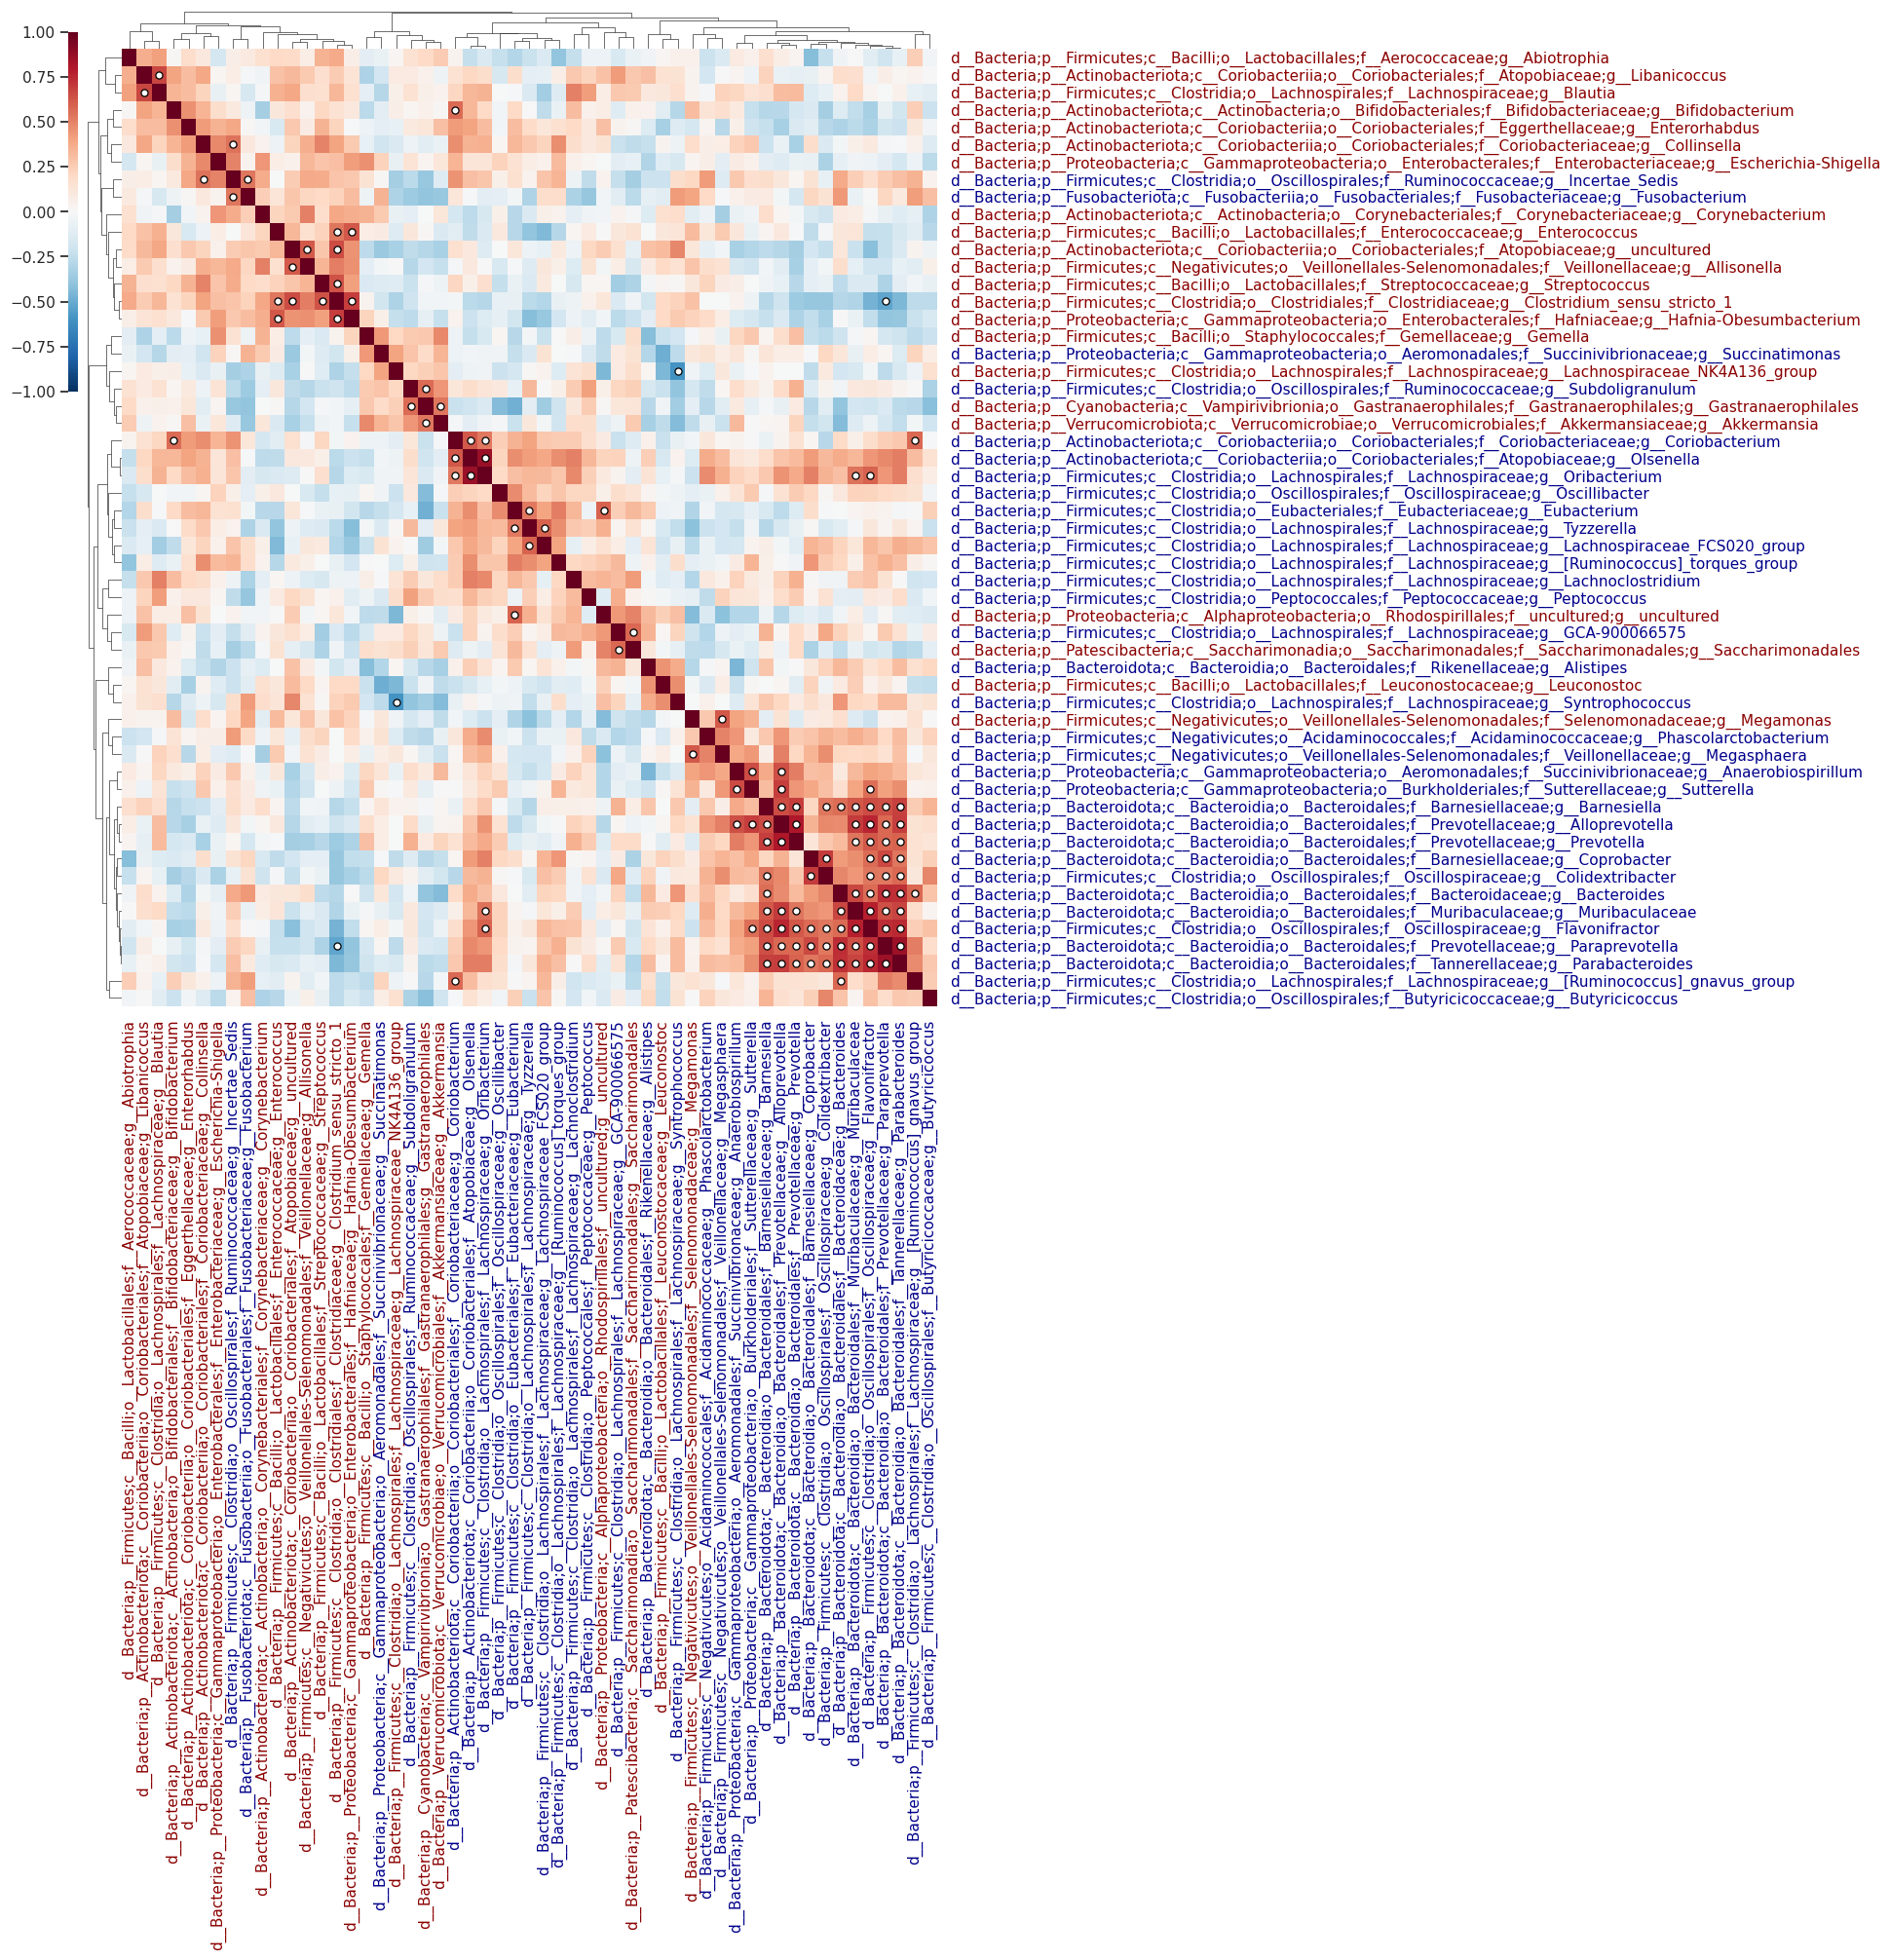

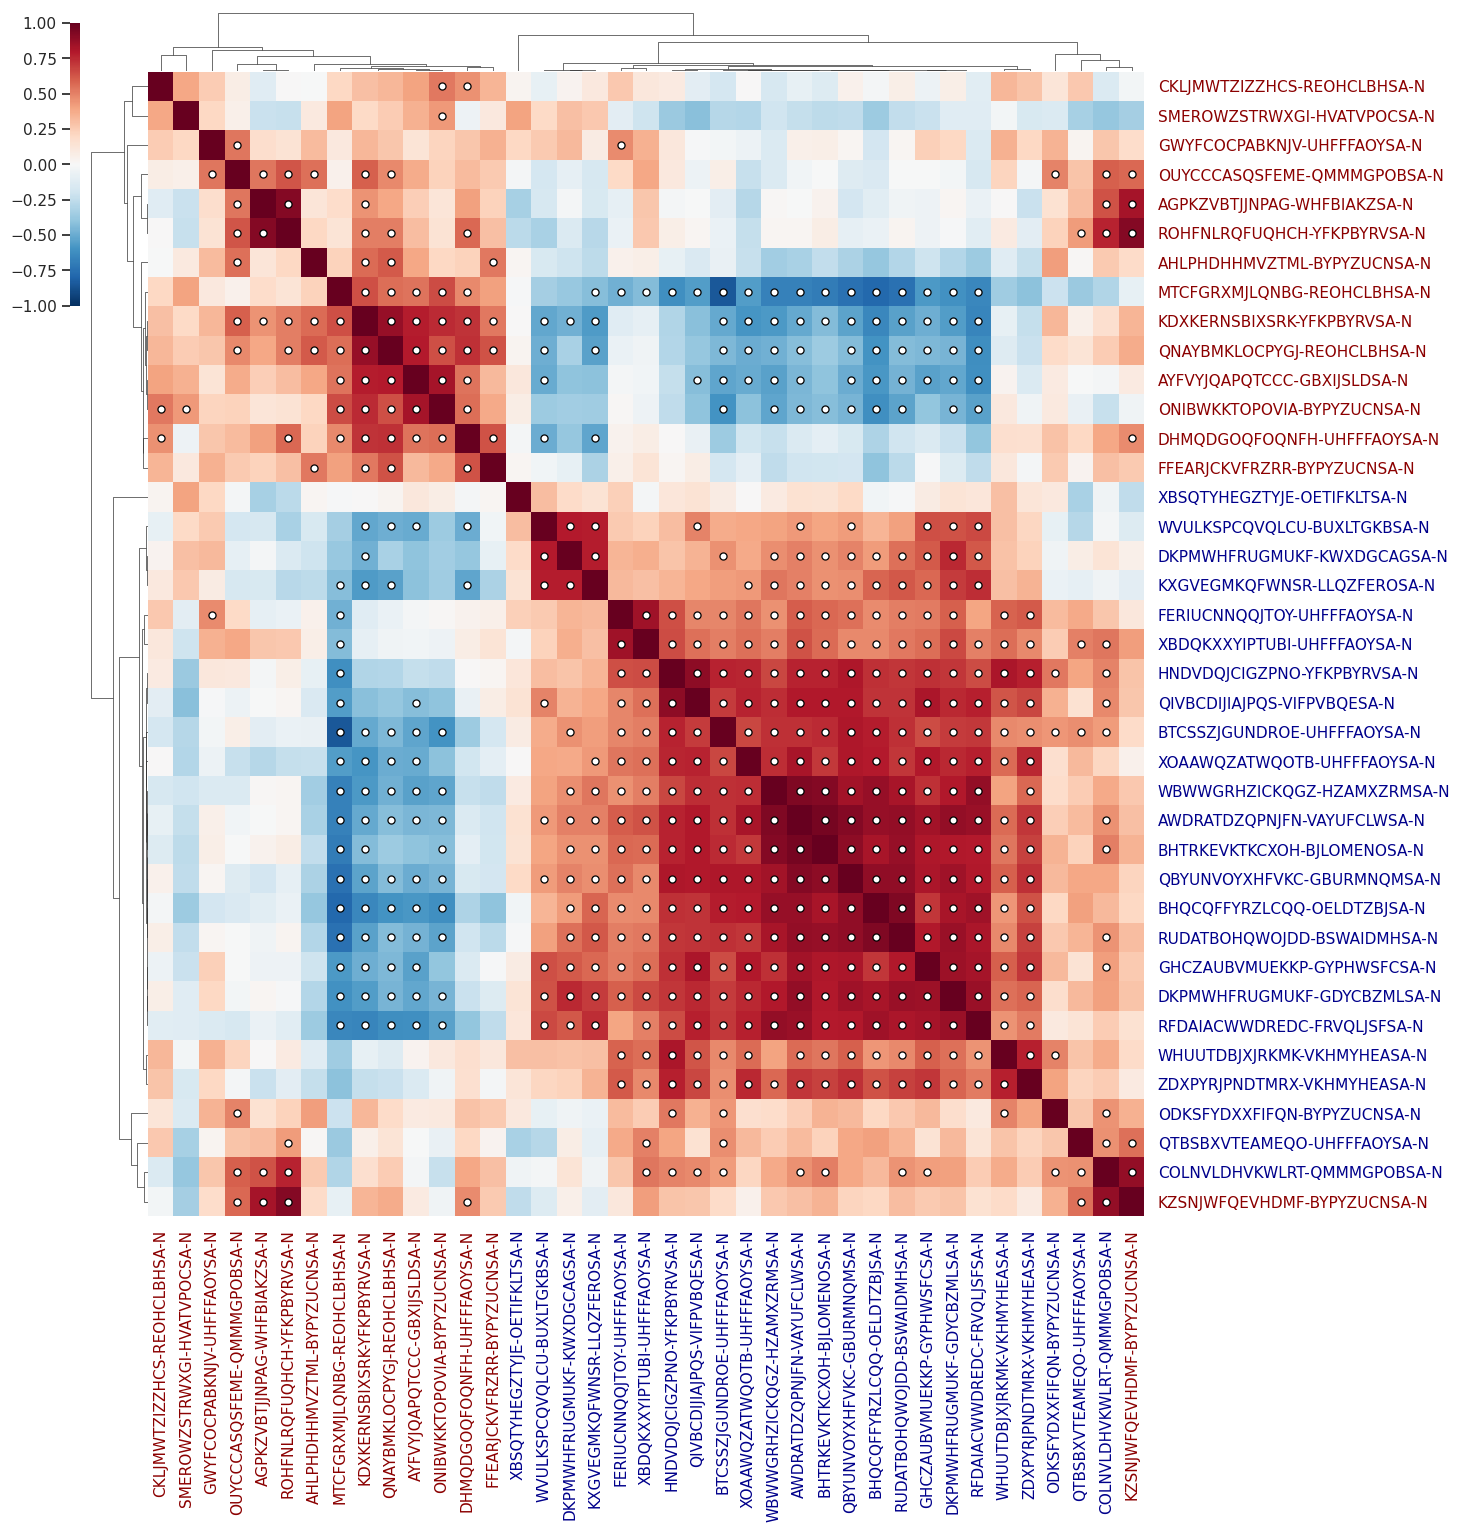

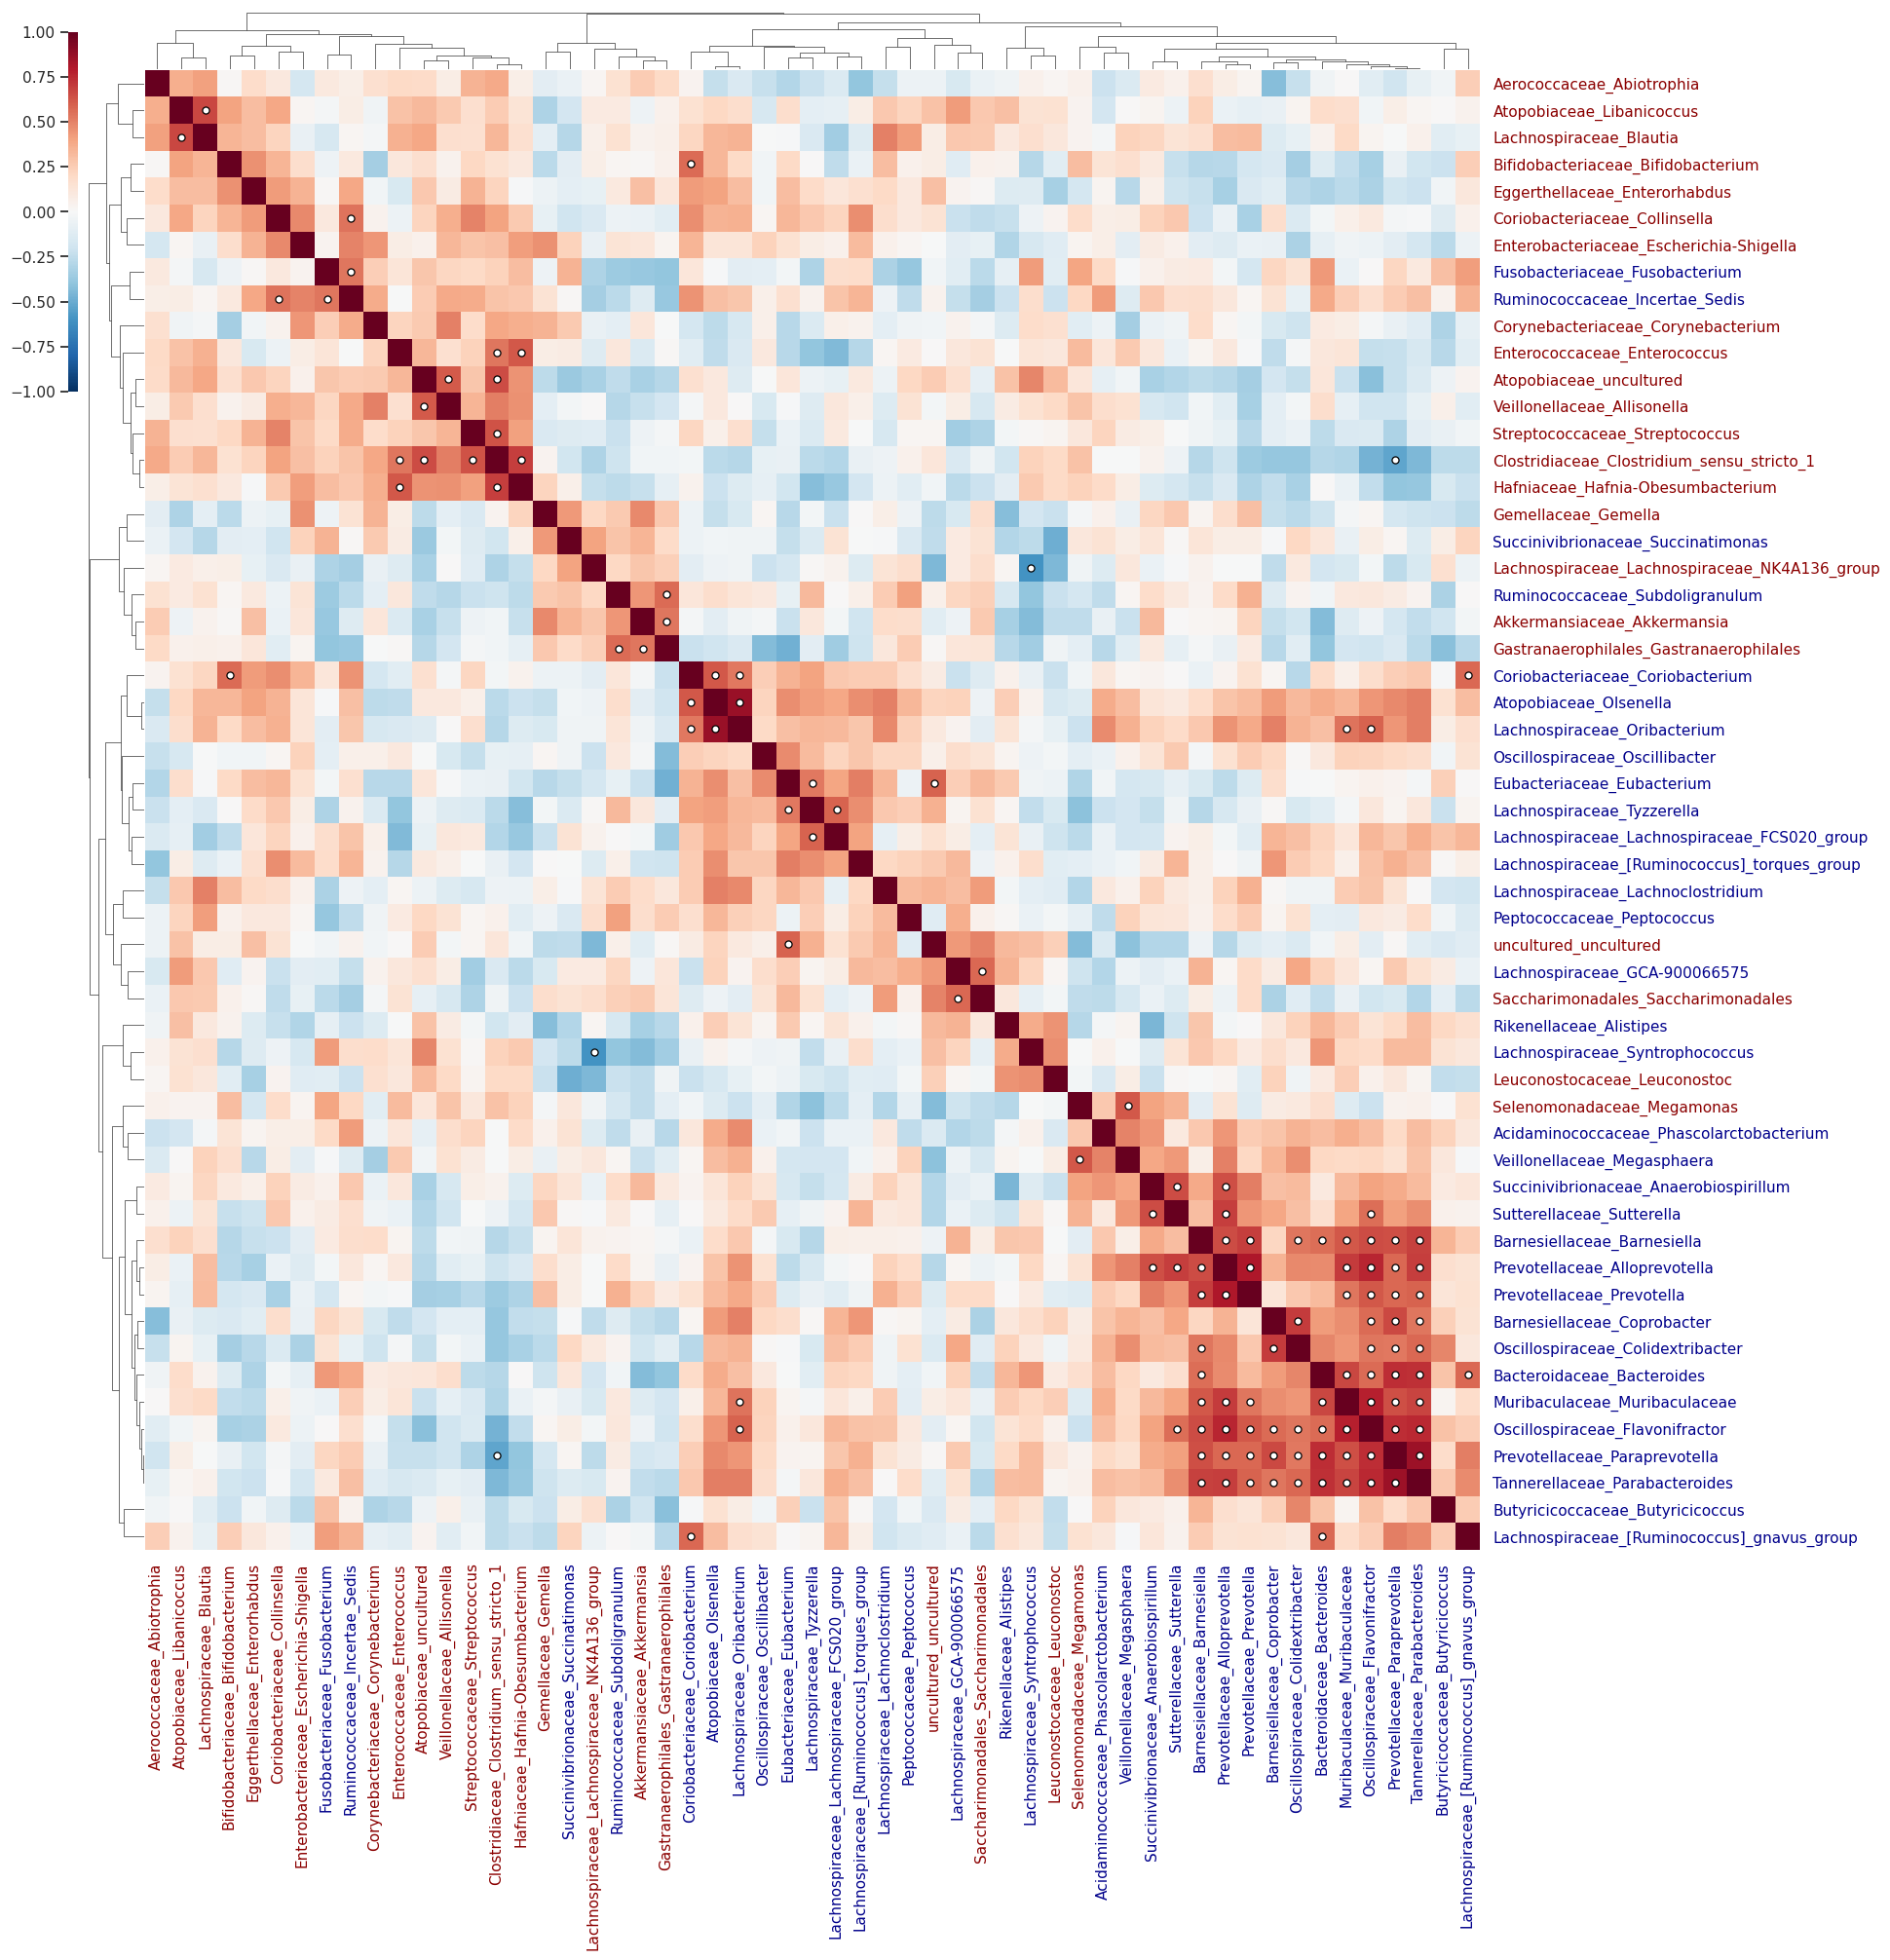

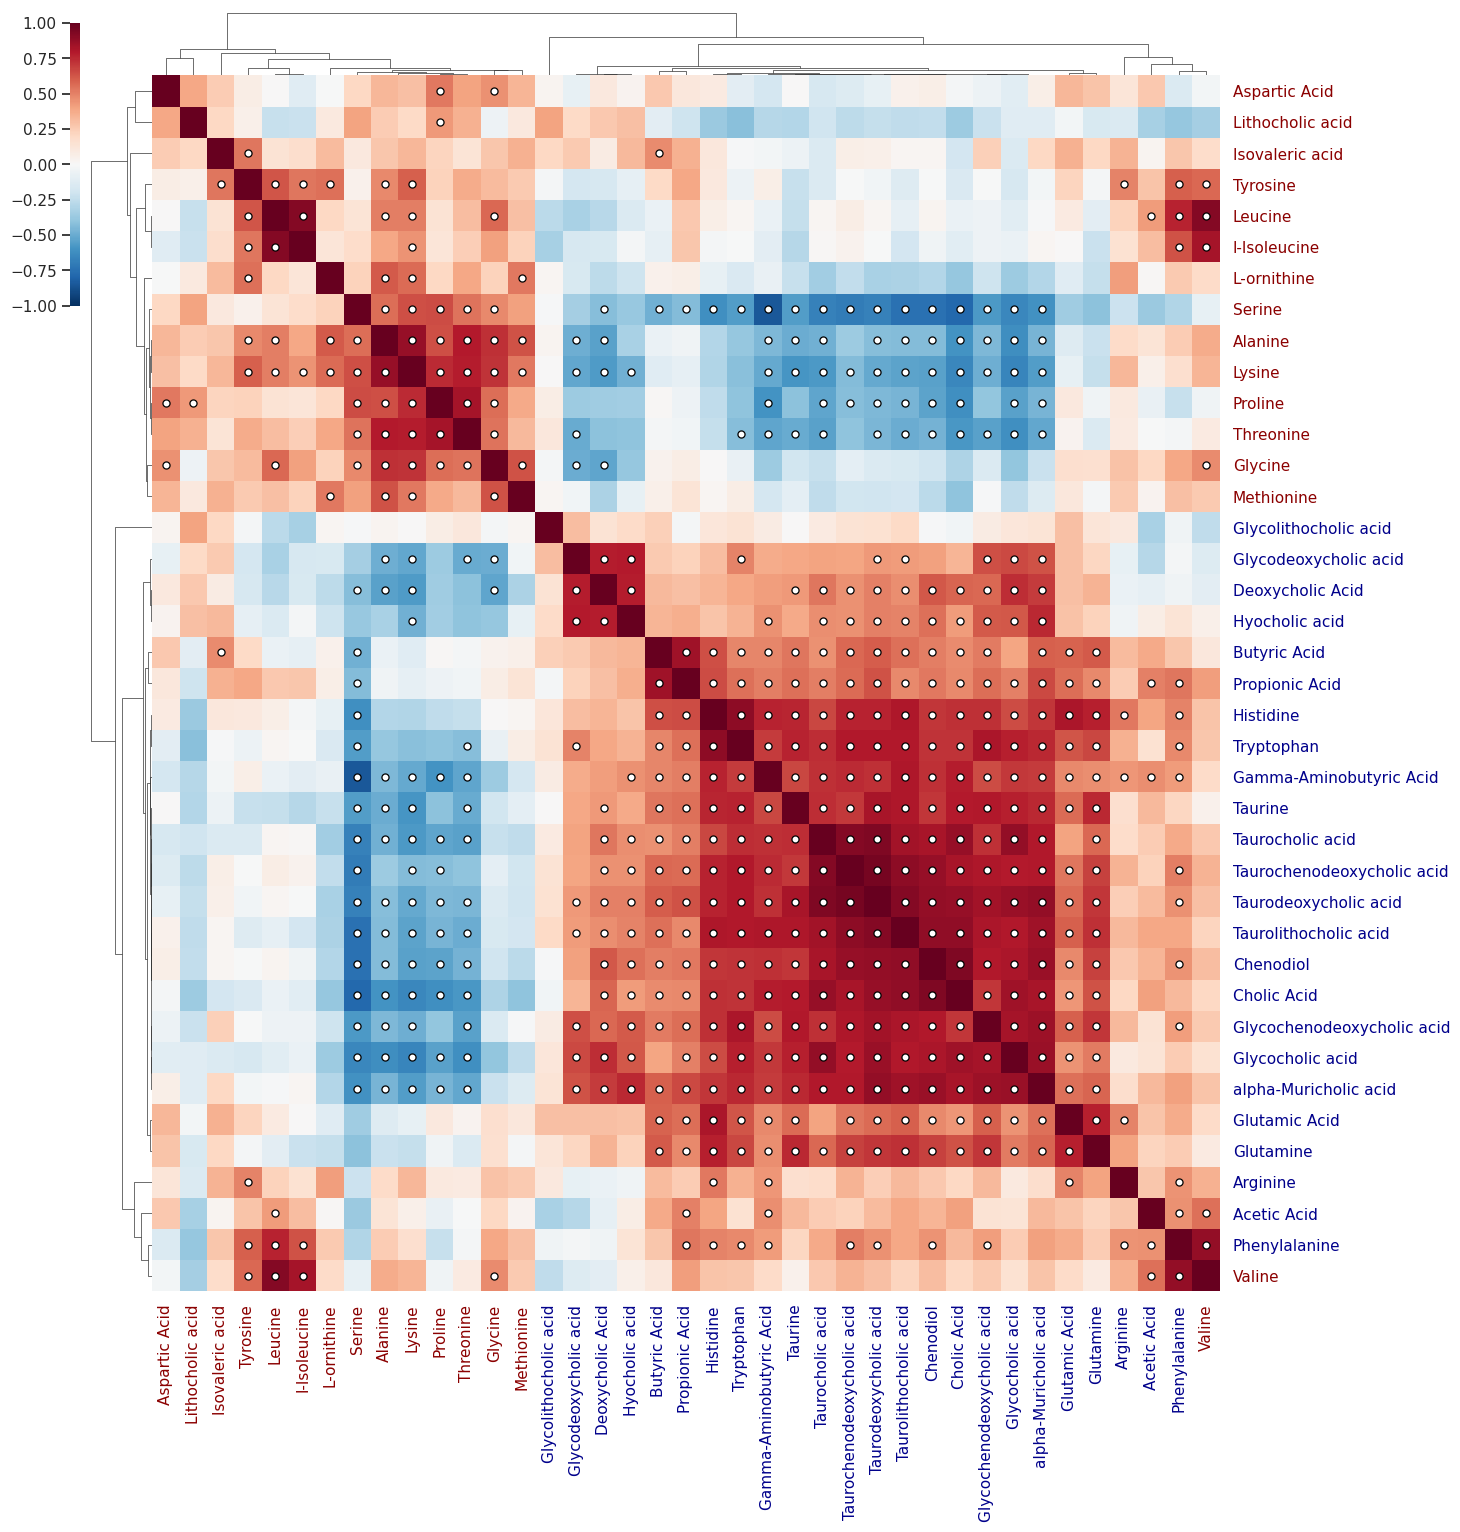

In [32]:
hallaOutput = hallaBasepath.joinpath('metab_dsets_combined')
pat = re.compile('^.+\/(.+)-(.+)$')

for dir in hallaOutput.iterdir():
    with open(nodeDir.joinpath('labels.tsv'), 'w') as f:
        f.write('Feature\tEigenvector\tLabel\n')
        for d in dir.iterdir():
            match = pat.match(str(d))
            
            # Symmetrical matrices are processed differently than asymmetrical ones
            if match and match.group(1) == match.group(2):
                associations = pd.read_csv(d.joinpath('all_associations.txt'), sep='\t').pivot(index = 'X_features', columns='Y_features')
    
                # For symmetric matrices, the first eigenvector from the eigendecomposed correlation matrix is used to classify
                # each feature into 'Positive' or 'Negative' correlation type
                X = associations['association'].to_numpy()
                pca = sklearn.decomposition.PCA()
                pca.fit(X)
                pc1 = pca.components_[:1,:]
                cortypes = pd.DataFrame(pc1.T, index=associations['association'].columns, columns=['Eigenvector'])
                cortypes['Label'] = cortypes['Eigenvector'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
                cortypes['Color'] = cortypes['Label'].apply(lambda x: 'darkred' if x == 'Positive' else 'darkblue')

                if dir.name == 'non_graphical_output':
                    cortypes.to_csv(f, mode='a', sep='\t', index=True, header=False)
                
                # A clustermap is created with features labeled according to their eigenvector
                sim_table = associations['association']
                qvals = associations['q-values']
                fdr_reject_table = (qvals < 0.05).to_numpy()
                vmax, vmin = sim_table.values.max(), sim_table.values.min()
                
                if vmin < 0 and vmax > 0:
                    vmax = max(abs(vmin), vmax)
                    vmin = -vmax
                figsize = (max(5, 0.3*sim_table.shape[1]+2.5), max(5, 0.3*sim_table.shape[0]+4))
                dendrogram_ratio = (0.8/figsize[0], 0.8/figsize[1])
                cbar_pos = (0, 0.8, 0.1/figsize[0], 0.18)
                cbar_kws = { 'label': '', 'ticklocation': 'left' }
                clustermap = sns.clustermap(sim_table, metric='correlation', cmap='RdBu_r', vmin=vmin, vmax=vmax, figsize=figsize, dendrogram_ratio=dendrogram_ratio, 
                                            cbar_pos=cbar_pos, cbar_kws=cbar_kws, zorder=2, xticklabels=sim_table.index, yticklabels=sim_table.columns
                )
                ax = clustermap.ax_heatmap
                ax.set_xlabel('', fontweight='bold')
                ax.set_ylabel('', fontweight='bold')
                ax.tick_params(right=False)
                
                # Features are colored according to their eigenvector (Red if positive, Blue if negative)
                for xtick, ytick in zip(ax.get_xticklabels(), ax.get_yticklabels()):
                    xtick.set_color(cortypes.loc[xtick.get_text(), 'Color'])
                    ytick.set_color(cortypes.loc[ytick.get_text(), 'Color'])
                  
                # Significant correlations are marked with a white dot, as in the HAllA source code
                dot_order_x = np.asarray(clustermap.dendrogram_row.reordered_ind)
                dot_order_y = clustermap.dendrogram_col.reordered_ind
                for i in range(len(sim_table.index)):
                    for j in range(len(sim_table.columns)):
                        if fdr_reject_table[dot_order_x[i],dot_order_y[j]] and i != j:
                            ax.scatter(y = i + .5, x = j + .5, c = 'black', marker = "o", zorder = 3, s = 25)
                            ax.scatter(y = i + .5, x = j + .5, c = 'white', marker = "o", zorder = 3, s = 10)
                            
                if dir.name == 'non_graphical_output':
                    plt.savefig(figureDir.joinpath(d.name + '_fullname_clustergram.pdf'), format='pdf', bbox_inches='tight')
                else:
                    plt.savefig(figureDir.joinpath(d.name + '_clustergram.pdf'), format='pdf', bbox_inches='tight')